## Initialization library, data, & function

In [115]:
#load all the necessary python libraries to preprocess the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm, skew

pd.options.display.float_format = "{:.2f}".format # float format 2 number in decimal, by kobud


In [116]:
import shap
shap.initjs()

In [117]:
# load data
df_ojol = pd.read_csv('dsa_ojol_dataset_clean1_v2.csv',delimiter="|")

In [209]:
# add by kobud
# referensi fungsi

# fungsi untuk menampilkan count of unique variabel
def showCountUniqueVariable(df):
    unique_counts = pd.DataFrame.from_records([(col, df[col].nunique(), df.dtypes[col]) 
                                           for col in df.columns],
                                          columns=['Column_Name', 'Num_Unique','Data_Type']).sort_values(by=['Num_Unique'])
    print(unique_counts)

# funsgis untuk memindah target variable ke last
def dependentToEndCol(df, colName):
    cols = list(df.columns.values)
    cols.pop(cols.index(colName))
    df = df[cols+[colName]]
    
    return df

# fungsi untuk cek missing value pada DF
def checkMissingValues(df):
    missing_data_clean = pd.DataFrame({'total_missing':df.isnull().sum(), 
                                     '%missing':(df.isnull().sum())/(df.isnull().count())*100})
    missing_data_clean = missing_data_clean[missing_data_clean['total_missing']>0]
    
    return missing_data_clean

# fungsi untuk variable baru numerical dan categorical
def defineNumCatCol(df):
    col_num = df.loc[:,df.dtypes != 'category'].columns
    col_cat = df.loc[:,df.dtypes == 'category'].columns
    col_type = {'col_num':col_num, 'col_cat':col_cat}
    
    return col_type

# fungsi konversi ke numerical & categorical variable by treshold jumlah unik values
def convertToCategoryType(df, tresh):
    treshold = tresh
    for col in df.columns:
        if df[col].nunique() < treshold:
            df[col] = df[col].astype('category')
    
    return df

# fungsi hitung banyak outliers
def numberOfOutliers(df, col_num):
    colname = [] 
    outlier = []
    percent = []
    for col_name in col_num:
        q1 = df[col_name].quantile(0.25)
        q3 = df[col_name].quantile(0.75)
        iqr = q3 - q1
        low = q1-(1.5*iqr)
        high = q1+(1.5*iqr)
        outliers1 = (len(df.loc[((df[col_name] < low) | (df[col_name] > high)), col_name]))
        outliers2 = ((len(df.loc[((df[col_name] < low) | (df[col_name] > high)), col_name]))/len(df_ojol))*100 
        colname.append(col_name)
        outlier.append(outliers1)
        percent.append("%.2f"%outliers2)
        
    df_outliers = pd.DataFrame({'col_name':colname, 'outlier':outlier, 'percent':percent})
    return df_outliers

# DATA UNDERSTANDING

## Explore Data

In [162]:
print("{} rows x {} columns".format(df_ojol.shape[0], df_ojol.shape[1])) 

695597 rows x 31 columns


In [163]:
df_ojol.head()

msisdn mytsel_app_user  total_revenue  rev_voice  rev_sms  \
0  628111563256               1          10092       8132      800   
1  628112589620               0         133657     131622     1410   
2  628112821723               0          30006      28556     1450   
3  628113288867               1          44503       7133      200   
4  628113917571               1           5073       4473      600   

   rev_broadband  rev_voice_pack  rev_sms_pack  rev_data_pack  \
0              0               0             0              0   
1              0               0             0              0   
2              0               0             0              0   
3              0               0             0              0   
4              0               0             0              0   

   rev_pack_mytsel  ... trx_sms_offnet   payload total_recharge_mytsel  \
0                0  ...              0   9229653                     0   
1                0  ...              1   3668863                     0   
2                0  ...              5   2097283                     0   
3                0  ...              0   1974025                     0   
4                0  ...              0  10023262                     0   

   total_recharge_urp                region  flag_taker   los  \
0                   0  06.Eastern Jabotabek           0  1506   
1                   0             08.Jateng           0  1349   
2                   0             08.Jateng           0   775   
3                   0              09.Jatim           0  1485   
4                   0          10.Balinusra           0  1130   

   first_rank_category  ojol  total_recharge  
0       Transportation     Y           10000  
1       Transportation   NaN          135000  
2       Transportation   NaN           30000  
3                Games     Y           15000  
4       Transportation     Y           15000  

[5 rows x 31 columns]

In [164]:
df_ojol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695597 entries, 0 to 695596
Data columns (total 31 columns):
msisdn                   695597 non-null int64
mytsel_app_user          695597 non-null category
total_revenue            695597 non-null int64
rev_voice                695597 non-null int64
rev_sms                  695597 non-null int64
rev_broadband            695597 non-null int64
rev_voice_pack           695597 non-null int64
rev_sms_pack             695597 non-null int64
rev_data_pack            695597 non-null int64
rev_pack_mytsel          695597 non-null int64
rev_voice_pack_mytsel    695597 non-null category
rev_sms_pack_mytsel      695597 non-null category
rev_data_pack_mytsel     695597 non-null category
trx_voice                695597 non-null int64
trx_voice_onnet          695597 non-null int64
trx_voice_offnet         695597 non-null int64
mou_voice                695597 non-null int64
mou_voice_onnet          695597 non-null int64
mou_voice_offnet         695597

category     9
int64       22
dtype: int64


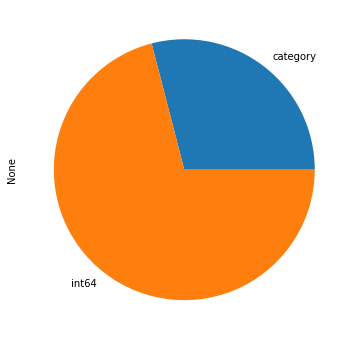

In [165]:
dcounts = df_ojol.get_dtype_counts()
print(dcounts)
labels = dcounts
plot = dcounts.plot.pie(figsize=(9, 6))

In [166]:
df_ojol.describe().T

count          mean          std          min  \
msisdn                695597 6213143252678 620748564893 628111563256   
total_revenue         695597        128579       102930            3   
rev_voice             695597          9242        24155            0   
rev_sms               695597          1051         3918            0   
rev_broadband         695597        108742        79503            0   
rev_voice_pack        695597          3548        15946            0   
rev_sms_pack          695597            28         1274            0   
rev_data_pack         695597        104255        77403            0   
rev_pack_mytsel       695597         12643        58688            0   
trx_voice             695597           107          143            1   
trx_voice_onnet       695597            81          123            0   
trx_voice_offnet      695597            22           35            0   
mou_voice             695597           177          389            0   
mou_voice_onnet       695597           151          381            0   
mou_voice_offnet      695597            20           39            0   
trx_sms               695597            16           94            1   
trx_sms_onnet         695597            13           78            0   
trx_sms_offnet        695597             3           37            0   
payload               695597      18562071     14422573            1   
total_recharge_mytsel 695597           710        27240            0   
los                   695597          1630         1788            1   
total_recharge        695597        129171       125605         1000   

                                25%           50%           75%           max  
msisdn                6281289284999 6281381932980 6282245001600 6285399999929  
total_revenue                 75460         99196        160001      23756492  
rev_voice                         0             0          7467       2348500  
rev_sms                           0           165           825        591000  
rev_broadband                 75000         78801        150000      13225000  
rev_voice_pack                    0             0             0       2348500  
rev_sms_pack                      0             0             0        591000  
rev_data_pack                 75000         75000        150000      13225000  
rev_pack_mytsel                   0             0             0      14265600  
trx_voice                        19            55           135          5606  
trx_voice_onnet                  11            36            99          3898  
trx_voice_offnet                  2             9            28          1693  
mou_voice                        19            69           191         24798  
mou_voice_onnet                   9            43           151         24772  
mou_voice_offnet                  1             6            23          2426  
trx_sms                           2             5            12         21210  
trx_sms_onnet                     1             3             8         19033  
trx_sms_offnet                    0             0             2         20063  
payload                     8643818      16331959      24959036     289082688  
total_recharge_mytsel             0             0             0      12750000  
los                             567          1083          1977          8985  
total_recharge                75000        100000        160000      23756000

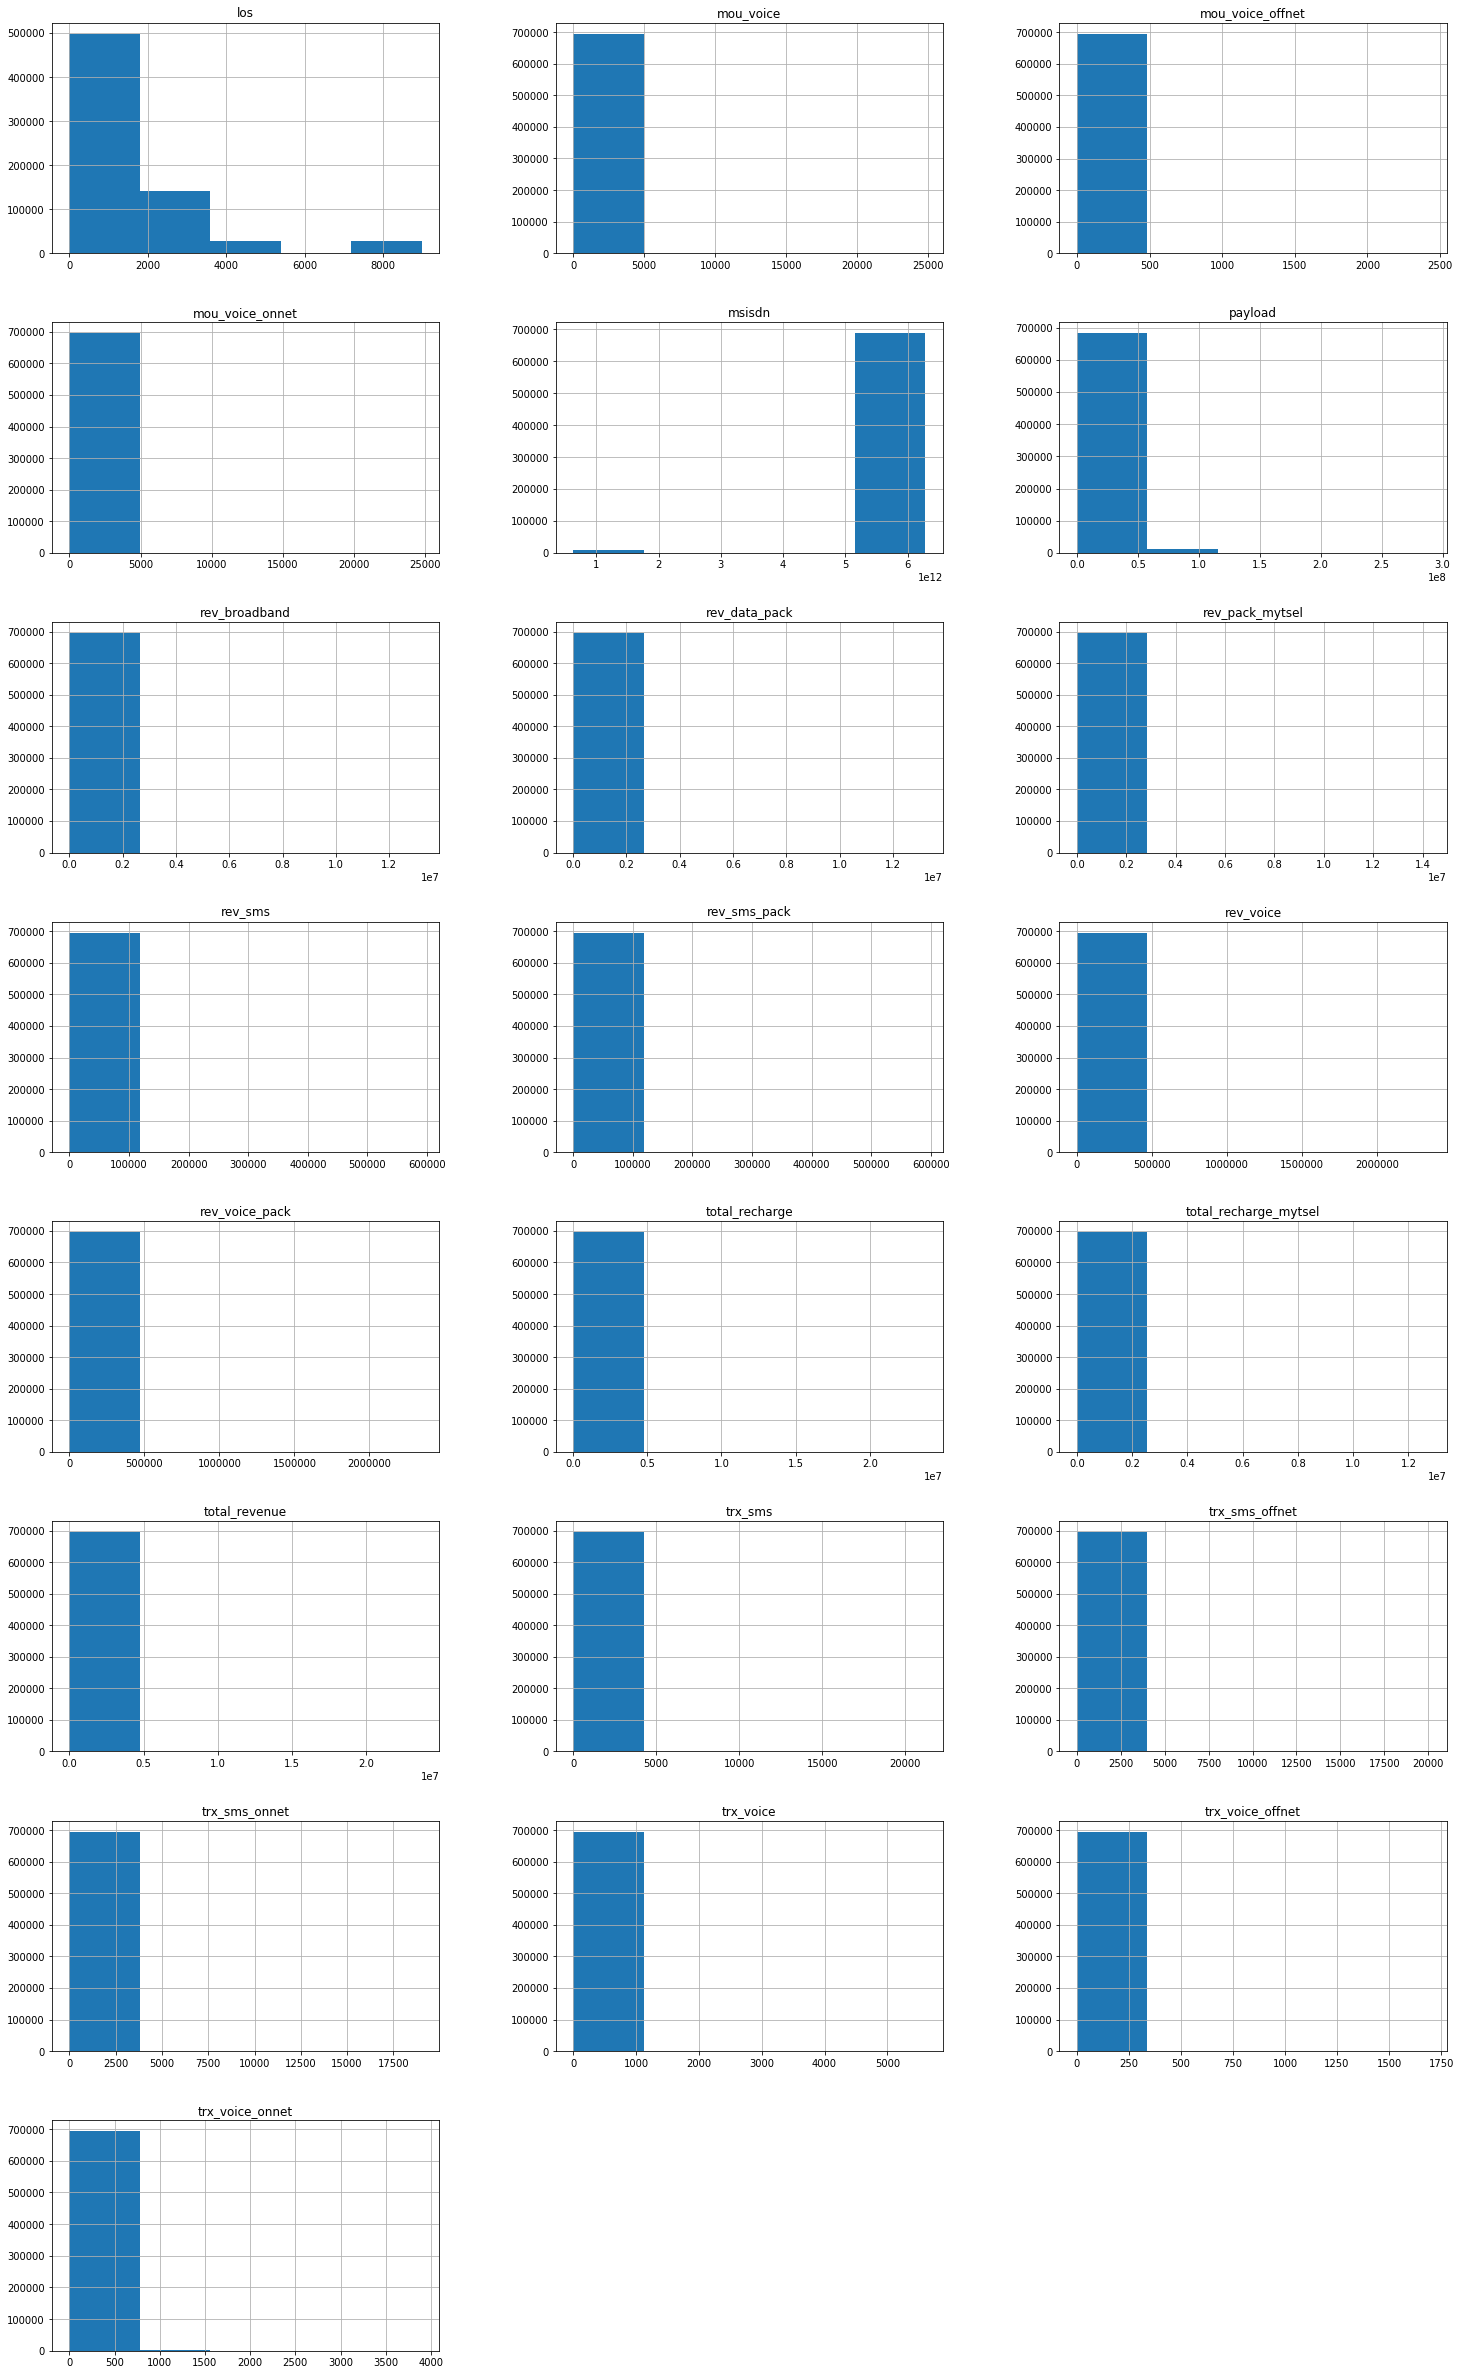

In [167]:
df_ojol.hist(bins=5, figsize=(25, 120), layout=(22, 3));

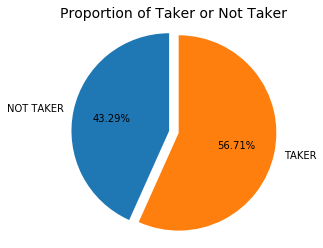

In [168]:
labels = 'NOT TAKER', 'TAKER'
sizes = [df_ojol.flag_taker[df_ojol['flag_taker']==0].count(), df_ojol.flag_taker[df_ojol['flag_taker']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(4, 4))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        startangle=90)
ax1.axis('equal')
plt.title("Proportion of Taker or Not Taker", size=14)
plt.show()

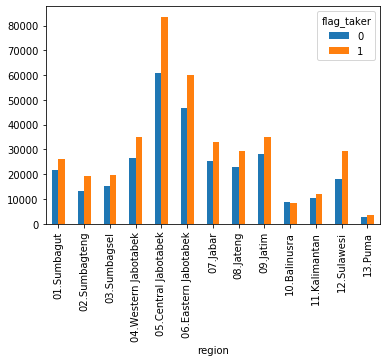

In [169]:
df_ojol.groupby('flag_taker').region.value_counts().unstack(0).plot.bar()

[]

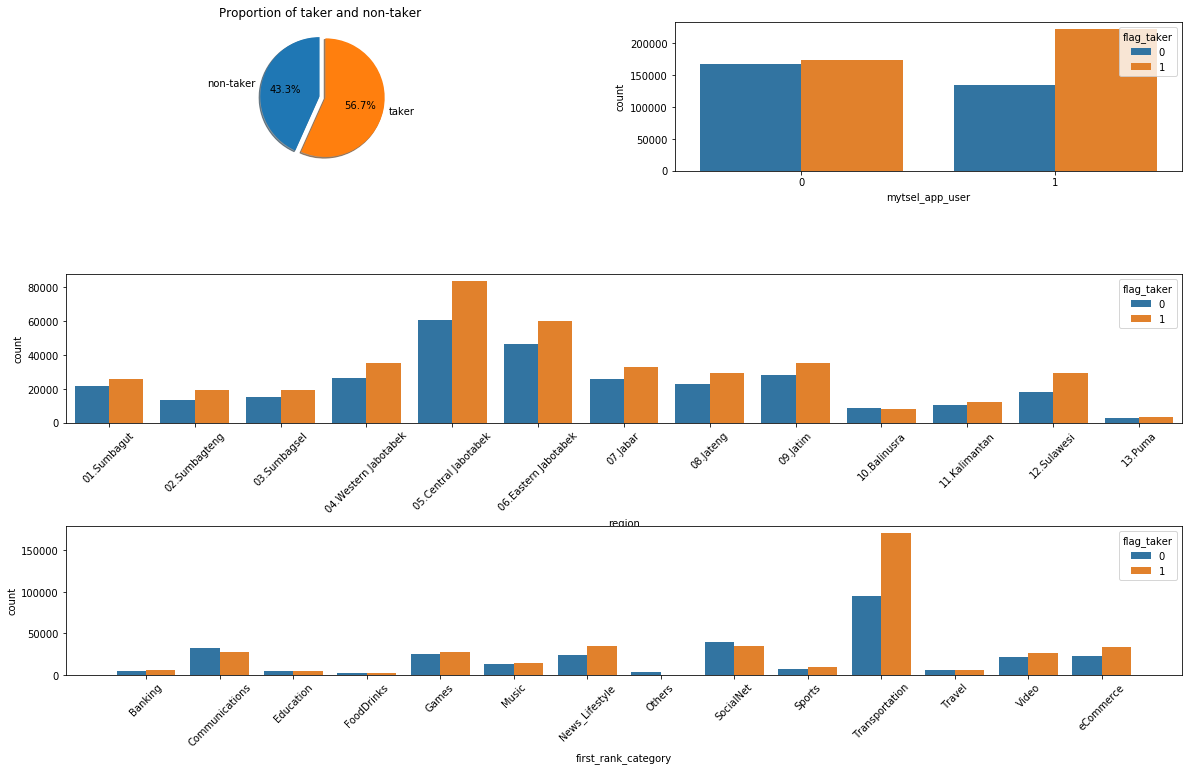

In [170]:
# add by kobud

plt.figure(figsize=(20,12))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
ax3.tick_params('x', labelrotation=45)
ax4 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
ax4.tick_params('x', labelrotation=45)

ax1.set_title('Proportion of taker and non-taker')

labels = 'non-taker', 'taker'
sizes = [df_ojol.flag_taker[df_ojol['flag_taker']==0].count(), df_ojol.flag_taker[df_ojol['flag_taker']==1].count()]
explode = (0, 0.1)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

sns.countplot(x='mytsel_app_user', hue = 'flag_taker',data = df_ojol, ax=ax2)
sns.countplot(x='region', hue = 'flag_taker',data = df_ojol, ax=ax3)
sns.countplot(x='first_rank_category', hue = 'flag_taker',data = df_ojol, ax=ax4)

# plt.margins(0.9)
plt.subplots_adjust(hspace=.7)
plt.plot()


## Duplicate Data

In [171]:
df_ojol.duplicated().sum()

0

## Missing Values

In [172]:
checkMissingValues(df_ojol)

total_missing  %missing
first_rank_category           5078         1
ojol                        340026        49

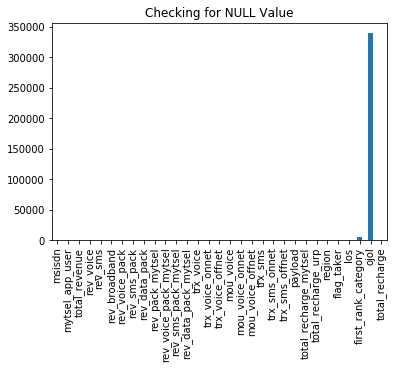

In [173]:
ojol_miss = df_ojol.isnull().sum().plot(kind='bar', title='Checking for NULL Value');

In [174]:
print("NULL: ", df_ojol['first_rank_category'].isnull().sum())
print("Not NULL: ", df_ojol['first_rank_category'].notnull().sum())

NULL:  5078
Not NULL:  690519


In [175]:
print("NULL: ", df_ojol['ojol'].isnull().sum())
print("Not NULL: ", df_ojol['ojol'].notnull().sum())

NULL:  340026
Not NULL:  355571


## Numerical & Categorical

In [176]:
showCountUniqueVariable(df_ojol)

              Column_Name  Num_Unique Data_Type
24     total_recharge_urp           1  category
10  rev_voice_pack_mytsel           1  category
11    rev_sms_pack_mytsel           1  category
12   rev_data_pack_mytsel           1  category
29                   ojol           1  category
1         mytsel_app_user           2  category
26             flag_taker           2  category
25                 region          13  category
28    first_rank_category          14  category
23  total_recharge_mytsel         111     int64
7            rev_sms_pack         209     int64
21         trx_sms_offnet         442     int64
15       trx_voice_offnet         469     int64
18       mou_voice_offnet         671     int64
30         total_recharge        1114     int64
20          trx_sms_onnet        1258     int64
19                trx_sms        1291     int64
14        trx_voice_onnet        1309     int64
13              trx_voice        1423     int64
9         rev_pack_mytsel        3674   

In [185]:
# add by Kobud
df_ojol = convertToCategoryType(df_ojol, 111)

In [186]:
showCountUniqueVariable(df_ojol)

              Column_Name  Num_Unique Data_Type
24     total_recharge_urp           1  category
10  rev_voice_pack_mytsel           1  category
11    rev_sms_pack_mytsel           1  category
12   rev_data_pack_mytsel           1  category
29                   ojol           1  category
1         mytsel_app_user           2  category
26             flag_taker           2  category
25                 region          13  category
28    first_rank_category          14  category
23  total_recharge_mytsel         111     int64
7            rev_sms_pack         209     int64
21         trx_sms_offnet         442     int64
15       trx_voice_offnet         469     int64
18       mou_voice_offnet         671     int64
30         total_recharge        1114     int64
20          trx_sms_onnet        1258     int64
19                trx_sms        1291     int64
14        trx_voice_onnet        1309     int64
13              trx_voice        1423     int64
9         rev_pack_mytsel        3674   

In [136]:
# add by kobud
col_type = defineNumCatCol(df_ojol)

display(df_ojol[col_type['col_num']].head())
display(df_ojol[col_type['col_cat']].head())

msisdn  total_revenue  rev_voice  rev_sms  rev_broadband  \
0  628111563256          10092       8132      800              0   
1  628112589620         133657     131622     1410              0   
2  628112821723          30006      28556     1450              0   
3  628113288867          44503       7133      200              0   
4  628113917571           5073       4473      600              0   

   rev_voice_pack  rev_sms_pack  rev_data_pack  rev_pack_mytsel  trx_voice  \
0               0             0              0                0         25   
1               0             0              0                0        186   
2               0             0              0                0         36   
3               0             0              0                0         22   
4               0             0              0                0        116   

   ...  mou_voice  mou_voice_onnet  mou_voice_offnet  trx_sms  trx_sms_onnet  \
0  ...          6                2                 3        4              4   
1  ...        102               63                38        7              6   
2  ...         21                4                16        7              2   
3  ...         21               17                 3        1              1   
4  ...        147              147                 0        6              6   

   trx_sms_offnet   payload  total_recharge_mytsel   los  total_recharge  
0               0   9229653                      0  1506           10000  
1               1   3668863                      0  1349          135000  
2               5   2097283                      0   775           30000  
3               0   1974025                      0  1485           15000  
4               0  10023262                      0  1130           15000  

[5 rows x 22 columns]

mytsel_app_user rev_voice_pack_mytsel rev_sms_pack_mytsel  \
0               1                     0                   0   
1               0                     0                   0   
2               0                     0                   0   
3               1                     0                   0   
4               1                     0                   0   

  rev_data_pack_mytsel total_recharge_urp                region flag_taker  \
0                    0                  0  06.Eastern Jabotabek          0   
1                    0                  0             08.Jateng          0   
2                    0                  0             08.Jateng          0   
3                    0                  0              09.Jatim          0   
4                    0                  0          10.Balinusra          0   

  first_rank_category ojol  
0      Transportation    Y  
1      Transportation  NaN  
2      Transportation  NaN  
3               Games    Y  
4      Transportation    Y

## Outliers

### Using the Interquartile Range (IQR)

In [137]:
# edited by kobud

Q1 = df_ojol.loc[:,col_num].quantile(0.25)
Q3 = df_ojol.loc[:,col_num].quantile(0.75)
IQR = Q3-Q1
Lower_Bound = Q1-(1.5*IQR)
Upper_Bound = Q3+(1.5*IQR)

outlier = pd.DataFrame({'Q1':Q1,'Q3':Q3,'IQR':IQR,'Lower_Bound':Lower_Bound,'Upper_Bound':Upper_Bound})
pd.options.display.float_format = '{:.0f}'.format
outlier

# Anything outside of lower_bound and upper_bound is an outlier.

Q1            Q3       IQR   Lower_Bound  \
msisdn                6281289284999 6282245001600 955716601 6279855710098   
total_revenue                 75460        160001     84541        -51352   
rev_voice                         0          7467      7467        -11200   
rev_sms                           0           825       825         -1238   
rev_broadband                 75000        150000     75000        -37500   
rev_voice_pack                    0             0         0             0   
rev_sms_pack                      0             0         0             0   
rev_data_pack                 75000        150000     75000        -37500   
rev_pack_mytsel                   0             0         0             0   
trx_voice                        19           135       116          -155   
trx_voice_onnet                  11            99        88          -121   
trx_voice_offnet                  2            28        26           -37   
mou_voice                        19           191       172          -239   
mou_voice_onnet                   9           151       142          -204   
mou_voice_offnet                  1            23        22           -32   
trx_sms                           2            12        10           -13   
trx_sms_onnet                     1             8         7           -10   
trx_sms_offnet                    0             2         2            -3   
payload                     8643818      24959036  16315218     -15829009   
total_recharge_mytsel             0             0         0             0   
los                             567          1977      1410         -1548   
total_recharge                75000        160000     85000        -52500   

                        Upper_Bound  
msisdn                6283678576502  
total_revenue                286812  
rev_voice                     18668  
rev_sms                        2062  
rev_broadband                262500  
rev_voice_pack                    0  
rev_sms_pack                      0  
rev_data_pack                262500  
rev_pack_mytsel                   0  
trx_voice                       309  
trx_voice_onnet                 231  
trx_voice_offnet                 67  
mou_voice                       449  
mou_voice_onnet                 364  
mou_voice_offnet                 56  
trx_sms                          27  
trx_sms_onnet                    18  
trx_sms_offnet                    5  
payload                    49431863  
total_recharge_mytsel             0  
los                            4092  
total_recharge               287500

### Number of Outliers

In [138]:
# edited by Kobud
display(numberOfOutliers(df_ojol, col_num))

col_name  outlier percent
0                  msisdn   105523   15.17
1           total_revenue   101402   14.58
2               rev_voice   139850   20.11
3                 rev_sms   128426   18.46
4           rev_broadband    83030   11.94
5          rev_voice_pack   106021   15.24
6            rev_sms_pack     2240    0.32
7           rev_data_pack    76243   10.96
8         rev_pack_mytsel    75485   10.85
9               trx_voice   114058   16.40
10        trx_voice_onnet   117866   16.94
11       trx_voice_offnet   115970   16.67
12              mou_voice   118329   17.01
13        mou_voice_onnet   124684   17.92
14       mou_voice_offnet   116365   16.73
15                trx_sms   119116   17.12
16          trx_sms_onnet   133550   19.20
17         trx_sms_offnet   109752   15.78
18                payload    91819   13.20
19  total_recharge_mytsel     3484    0.50
20                    los   109963   15.81
21         total_recharge   100026   14.38

(0.0, 1.0, 0.0, 1.0)

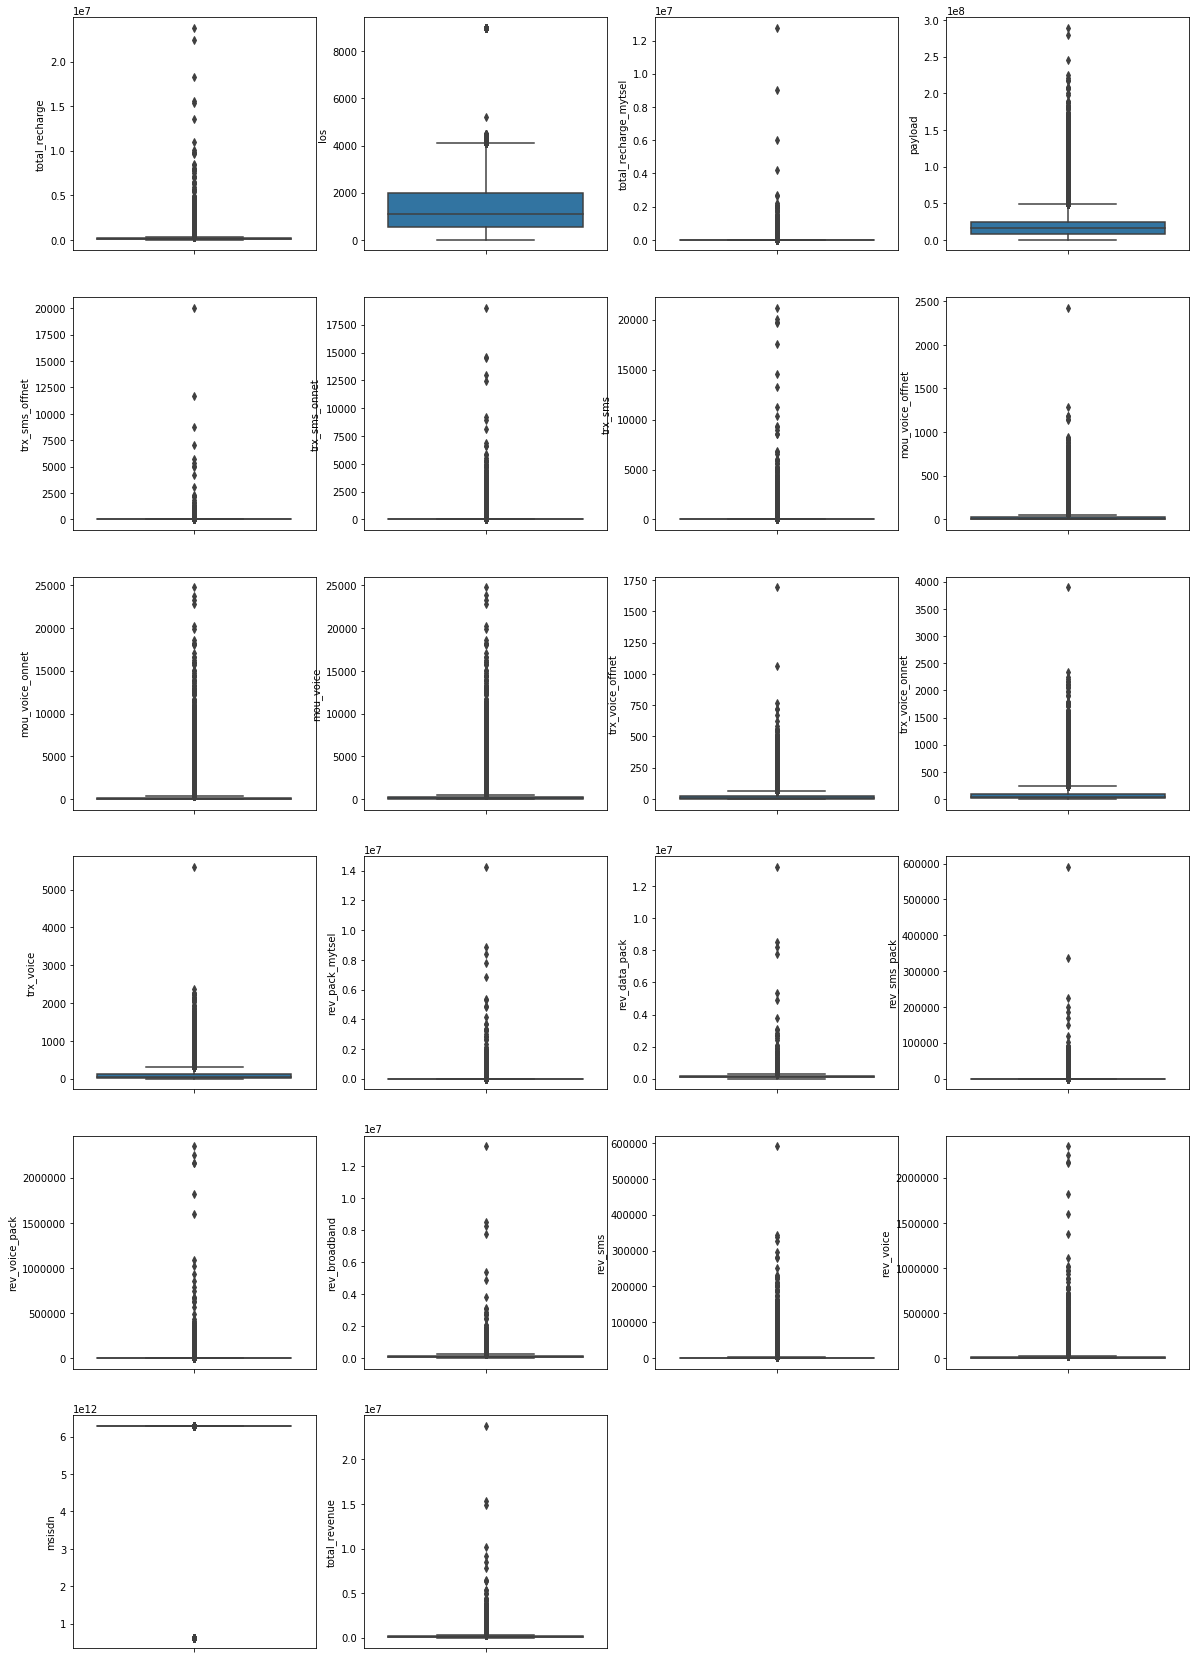

In [139]:
#edited by kobud

def convertColList(list, jml_col):
    b = []
    for i in a:
        c = []
        for j in range(jml_col):
            c.append(a.pop())
        b.append(c)
    b.append(a)
    return b

a = list(col_num.copy())
b = convertColList(a,4)
# print(b)
        
n = 0
fig, axarr = plt.subplots(6, 4, figsize=(20, 30))
for i in b:
    m = 0
    for j in i:
        if j in col_num:
            sns.boxplot(y=j, data = df_ojol , ax=axarr[n][m])
        
        m = m + 1
    n = n + 1

axarr[5, 2].axis('off')
axarr[5, 3].axis('off')


# DATA PREPARATION

## Data Preprocessing & Cleaning

In [140]:
df_ojol_prep = df_ojol.copy()

### Handling Missing Values

In [141]:
df_ojol_prep['ojol'].value_counts()

Y    355571
Name: ojol, dtype: int64

In [142]:
df_ojol_prep['ojol'] = df_ojol_prep['ojol'].replace(np.NaN,0).replace('Y',1)
df_ojol_prep.head(5)

msisdn mytsel_app_user  total_revenue  rev_voice  rev_sms  \
0  628111563256               1          10092       8132      800   
1  628112589620               0         133657     131622     1410   
2  628112821723               0          30006      28556     1450   
3  628113288867               1          44503       7133      200   
4  628113917571               1           5073       4473      600   

   rev_broadband  rev_voice_pack  rev_sms_pack  rev_data_pack  \
0              0               0             0              0   
1              0               0             0              0   
2              0               0             0              0   
3              0               0             0              0   
4              0               0             0              0   

   rev_pack_mytsel  ... trx_sms_offnet   payload total_recharge_mytsel  \
0                0  ...              0   9229653                     0   
1                0  ...              1   3668863                     0   
2                0  ...              5   2097283                     0   
3                0  ...              0   1974025                     0   
4                0  ...              0  10023262                     0   

   total_recharge_urp                region  flag_taker   los  \
0                   0  06.Eastern Jabotabek           0  1506   
1                   0             08.Jateng           0  1349   
2                   0             08.Jateng           0   775   
3                   0              09.Jatim           0  1485   
4                   0          10.Balinusra           0  1130   

   first_rank_category  ojol  total_recharge  
0       Transportation     1           10000  
1       Transportation     0          135000  
2       Transportation     0           30000  
3                Games     1           15000  
4       Transportation     1           15000  

[5 rows x 31 columns]

In [143]:
df_ojol_prep['ojol'].value_counts()

1    355571
0    340026
Name: ojol, dtype: int64

In [144]:
checkMissingValues(df_ojol_prep)

total_missing  %missing
first_rank_category           5078         1

In [145]:
df_ojol_prep['first_rank_category'] = df_ojol_prep['first_rank_category'].replace(np.NaN,'undefined')
df_ojol_prep['first_rank_category'].isnull().sum()

0

In [146]:
df_ojol_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695597 entries, 0 to 695596
Data columns (total 31 columns):
msisdn                   695597 non-null int64
mytsel_app_user          695597 non-null category
total_revenue            695597 non-null int64
rev_voice                695597 non-null int64
rev_sms                  695597 non-null int64
rev_broadband            695597 non-null int64
rev_voice_pack           695597 non-null int64
rev_sms_pack             695597 non-null int64
rev_data_pack            695597 non-null int64
rev_pack_mytsel          695597 non-null int64
rev_voice_pack_mytsel    695597 non-null category
rev_sms_pack_mytsel      695597 non-null category
rev_data_pack_mytsel     695597 non-null category
trx_voice                695597 non-null int64
trx_voice_onnet          695597 non-null int64
trx_voice_offnet         695597 non-null int64
mou_voice                695597 non-null int64
mou_voice_onnet          695597 non-null int64
mou_voice_offnet         695597

In [147]:
showCountUniqueVariable(df_ojol_prep)

              Column_Name  Num_Unique Data_Type
24     total_recharge_urp           1  category
10  rev_voice_pack_mytsel           1  category
11    rev_sms_pack_mytsel           1  category
12   rev_data_pack_mytsel           1  category
1         mytsel_app_user           2  category
26             flag_taker           2  category
29                   ojol           2     int64
25                 region          13  category
28    first_rank_category          15    object
23  total_recharge_mytsel         111     int64
7            rev_sms_pack         209     int64
21         trx_sms_offnet         442     int64
15       trx_voice_offnet         469     int64
18       mou_voice_offnet         671     int64
30         total_recharge        1114     int64
20          trx_sms_onnet        1258     int64
19                trx_sms        1291     int64
14        trx_voice_onnet        1309     int64
13              trx_voice        1423     int64
9         rev_pack_mytsel        3674   

### Drop feature have just 1 unique value

In [148]:
df_ojol_prep = df_ojol_prep.drop(['total_recharge_urp',
                                  'rev_voice_pack_mytsel',
                                  'rev_sms_pack_mytsel',
                                  'rev_data_pack_mytsel'
                                 ], axis = 1)

In [149]:
showCountUniqueVariable(df_ojol_prep)

              Column_Name  Num_Unique Data_Type
1         mytsel_app_user           2  category
22             flag_taker           2  category
25                   ojol           2     int64
21                 region          13  category
24    first_rank_category          15    object
20  total_recharge_mytsel         111     int64
7            rev_sms_pack         209     int64
18         trx_sms_offnet         442     int64
12       trx_voice_offnet         469     int64
15       mou_voice_offnet         671     int64
26         total_recharge        1114     int64
17          trx_sms_onnet        1258     int64
16                trx_sms        1291     int64
11        trx_voice_onnet        1309     int64
10              trx_voice        1423     int64
9         rev_pack_mytsel        3674     int64
14        mou_voice_onnet        4294     int64
13              mou_voice        4339     int64
23                    los        4467     int64
4                 rev_sms        4545   

### Drop feature have unique values as many as total data

In [150]:
df_ojol_prep = df_ojol_prep.drop(['msisdn'], axis = 1)

In [151]:
showCountUniqueVariable(df_ojol_prep)

              Column_Name  Num_Unique Data_Type
0         mytsel_app_user           2  category
21             flag_taker           2  category
24                   ojol           2     int64
20                 region          13  category
23    first_rank_category          15    object
19  total_recharge_mytsel         111     int64
6            rev_sms_pack         209     int64
17         trx_sms_offnet         442     int64
11       trx_voice_offnet         469     int64
14       mou_voice_offnet         671     int64
25         total_recharge        1114     int64
16          trx_sms_onnet        1258     int64
15                trx_sms        1291     int64
10        trx_voice_onnet        1309     int64
9               trx_voice        1423     int64
8         rev_pack_mytsel        3674     int64
13        mou_voice_onnet        4294     int64
12              mou_voice        4339     int64
22                    los        4467     int64
3                 rev_sms        4545   

### Drop feature have same values with other feature

In [152]:
print("Ojol have same value with MyTsel")
display(df_ojol_prep['ojol'].value_counts())
display(df_ojol_prep['mytsel_app_user'].value_counts())

Ojol have same value with MyTsel


1    355571
0    340026
Name: ojol, dtype: int64

1    355571
0    340026
Name: mytsel_app_user, dtype: int64

In [153]:
df_ojol_prep = df_ojol_prep.drop(['ojol'], axis = 1)

In [154]:
showCountUniqueVariable(df_ojol_prep)

              Column_Name  Num_Unique Data_Type
0         mytsel_app_user           2  category
21             flag_taker           2  category
20                 region          13  category
23    first_rank_category          15    object
19  total_recharge_mytsel         111     int64
6            rev_sms_pack         209     int64
17         trx_sms_offnet         442     int64
11       trx_voice_offnet         469     int64
14       mou_voice_offnet         671     int64
24         total_recharge        1114     int64
16          trx_sms_onnet        1258     int64
15                trx_sms        1291     int64
10        trx_voice_onnet        1309     int64
9               trx_voice        1423     int64
8         rev_pack_mytsel        3674     int64
13        mou_voice_onnet        4294     int64
12              mou_voice        4339     int64
22                    los        4467     int64
3                 rev_sms        4545     int64
5          rev_voice_pack        5235   

### Reshaping total_revenue to arpu_class

In [155]:
def segment_arpu(data):
    df_ojol_prep['segment_arpu'] = "NaN"
    df_ojol_prep.loc[(df_ojol_prep['total_revenue'] >= 0) & (df_ojol_prep['total_revenue'] <= 20000), 'segment_arpu'] = 'Very Low (<=20K)' 
    df_ojol_prep.loc[(df_ojol_prep['total_revenue'] > 20000) & (df_ojol_prep['total_revenue'] <= 50000), 'segment_arpu'] = 'Medium (20-50K)'
    df_ojol_prep.loc[(df_ojol_prep['total_revenue'] > 50000) & (df_ojol_prep['total_revenue'] <= 120000), 'segment_arpu'] = 'High (50-120K)'
    df_ojol_prep.loc[(df_ojol_prep['total_revenue'] > 120000) & (df_ojol_prep['total_revenue'] <= 250000), 'segment_arpu'] = 'Very High (120-250K)' 
    df_ojol_prep.loc[(df_ojol_prep['total_revenue'] > 250000), 'segment_arpu'] = 'Top Usage (>250K)'  
    return df_ojol_prep

df_ojol_prep = segment_arpu(df_ojol_prep)

In [156]:
df_ojol_prep.segment_arpu.value_counts()

High (50-120K)          341851
Very High (120-250K)    235543
Top Usage (>250K)        53768
Medium (20-50K)          38787
Very Low (<=20K)         25648
Name: segment_arpu, dtype: int64

### Reshaping los to los_range

In [157]:
bins = [0, 30, 90, 180, 270, 360, 1080, np.inf]
names = ['<30d', '1-3mo', '3-6mo', '6-9mo', '9-12mo', '1-3y', '3y+']

df_ojol_prep['los_range'] = pd.cut(df_ojol_prep['los'], bins, labels=names)

In [158]:
df_ojol_prep.los_range.value_counts()

3y+       348140
1-3y      262704
9-12mo     33260
6-9mo      23603
3-6mo      20233
1-3mo       7099
<30d         558
Name: los_range, dtype: int64

In [159]:
df_ojol_prep.head()

mytsel_app_user  total_revenue  rev_voice  rev_sms  rev_broadband  \
0               1          10092       8132      800              0   
1               0         133657     131622     1410              0   
2               0          30006      28556     1450              0   
3               1          44503       7133      200              0   
4               1           5073       4473      600              0   

   rev_voice_pack  rev_sms_pack  rev_data_pack  rev_pack_mytsel  trx_voice  \
0               0             0              0                0         25   
1               0             0              0                0        186   
2               0             0              0                0         36   
3               0             0              0                0         22   
4               0             0              0                0        116   

   ...  trx_sms_offnet   payload  total_recharge_mytsel                region  \
0  ...               0   9229653                      0  06.Eastern Jabotabek   
1  ...               1   3668863                      0             08.Jateng   
2  ...               5   2097283                      0             08.Jateng   
3  ...               0   1974025                      0              09.Jatim   
4  ...               0  10023262                      0          10.Balinusra   

   flag_taker   los  first_rank_category  total_recharge  \
0           0  1506       Transportation           10000   
1           0  1349       Transportation          135000   
2           0   775       Transportation           30000   
3           0  1485                Games           15000   
4           0  1130       Transportation           15000   

           segment_arpu  los_range  
0      Very Low (<=20K)        3y+  
1  Very High (120-250K)        3y+  
2       Medium (20-50K)       1-3y  
3       Medium (20-50K)        3y+  
4      Very Low (<=20K)        3y+  

[5 rows x 27 columns]

### Redefine Numerical & Categorical

In [182]:
showCountUniqueVariable(df_ojol_prep)

              Column_Name  Num_Unique Data_Type
0         mytsel_app_user           2  category
21             flag_taker           2  category
25           segment_arpu           5    object
26              los_range           7  category
20                 region          13  category
23    first_rank_category          15    object
19  total_recharge_mytsel         111     int64
6            rev_sms_pack         209     int64
17         trx_sms_offnet         442     int64
11       trx_voice_offnet         469     int64
14       mou_voice_offnet         671     int64
24         total_recharge        1114     int64
16          trx_sms_onnet        1258     int64
15                trx_sms        1291     int64
10        trx_voice_onnet        1309     int64
9               trx_voice        1423     int64
8         rev_pack_mytsel        3674     int64
13        mou_voice_onnet        4294     int64
12              mou_voice        4339     int64
22                    los        4467   

In [183]:
df_ojol_prep = convertToCategoryType(df_ojol_prep, 111)

In [184]:
showCountUniqueVariable(df_ojol_prep)

              Column_Name  Num_Unique Data_Type
0         mytsel_app_user           2  category
21             flag_taker           2  category
25           segment_arpu           5  category
26              los_range           7  category
20                 region          13  category
23    first_rank_category          15  category
19  total_recharge_mytsel         111     int64
6            rev_sms_pack         209     int64
17         trx_sms_offnet         442     int64
11       trx_voice_offnet         469     int64
14       mou_voice_offnet         671     int64
24         total_recharge        1114     int64
16          trx_sms_onnet        1258     int64
15                trx_sms        1291     int64
10        trx_voice_onnet        1309     int64
9               trx_voice        1423     int64
8         rev_pack_mytsel        3674     int64
13        mou_voice_onnet        4294     int64
12              mou_voice        4339     int64
22                    los        4467   

In [187]:
col_type = defineNumCatCol(df_ojol_prep)
print(col_type)

{'col_num': Index(['total_revenue', 'rev_voice', 'rev_sms', 'rev_broadband',
       'rev_voice_pack', 'rev_sms_pack', 'rev_data_pack', 'rev_pack_mytsel',
       'trx_voice', 'trx_voice_onnet', 'trx_voice_offnet', 'mou_voice',
       'mou_voice_onnet', 'mou_voice_offnet', 'trx_sms', 'trx_sms_onnet',
       'trx_sms_offnet', 'payload', 'total_recharge_mytsel', 'los',
       'total_recharge'],
      dtype='object'), 'col_cat': Index(['mytsel_app_user', 'region', 'flag_taker', 'first_rank_category',
       'segment_arpu', 'los_range'],
      dtype='object')}


### Handling Outliers

In [192]:
print("List of columns with outliers:")
display(numberOfOutliers(df_ojol_prep, col_type['col_num']))

List of columns with outliers:


col_name  outlier percent
0           total_revenue   101402   14.58
1               rev_voice   139850   20.11
2                 rev_sms   128426   18.46
3           rev_broadband    83030   11.94
4          rev_voice_pack   106021   15.24
5            rev_sms_pack     2240    0.32
6           rev_data_pack    76243   10.96
7         rev_pack_mytsel    75485   10.85
8               trx_voice   114058   16.40
9         trx_voice_onnet   117866   16.94
10       trx_voice_offnet   115970   16.67
11              mou_voice   118329   17.01
12        mou_voice_onnet   124684   17.92
13       mou_voice_offnet   116365   16.73
14                trx_sms   119116   17.12
15          trx_sms_onnet   133550   19.20
16         trx_sms_offnet   109752   15.78
17                payload    91819   13.20
18  total_recharge_mytsel     3484    0.50
19                    los   109963   15.81
20         total_recharge   100026   14.38

#### Replacing outliers with median values

In [198]:
df_ojol_prep.describe().T

count     mean      std  min     25%      50%      75%  \
total_revenue         695597   128579   102930    3   75460    99196   160001   
rev_voice             695597     9242    24155    0       0        0     7467   
rev_sms               695597     1051     3918    0       0      165      825   
rev_broadband         695597   108742    79503    0   75000    78801   150000   
rev_voice_pack        695597     3548    15946    0       0        0        0   
rev_sms_pack          695597       28     1274    0       0        0        0   
rev_data_pack         695597   104255    77403    0   75000    75000   150000   
rev_pack_mytsel       695597    12643    58688    0       0        0        0   
trx_voice             695597      107      143    1      19       55      135   
trx_voice_onnet       695597       81      123    0      11       36       99   
trx_voice_offnet      695597       22       35    0       2        9       28   
mou_voice             695597      177      389    0      19       69      191   
mou_voice_onnet       695597      151      381    0       9       43      151   
mou_voice_offnet      695597       20       39    0       1        6       23   
trx_sms               695597       16       94    1       2        5       12   
trx_sms_onnet         695597       13       78    0       1        3        8   
trx_sms_offnet        695597        3       37    0       0        0        2   
payload               695597 18562071 14422573    1 8643818 16331959 24959036   
total_recharge_mytsel 695597      710    27240    0       0        0        0   
los                   695597     1630     1788    1     567     1083     1977   
total_recharge        695597   129171   125605 1000   75000   100000   160000   

                            max  
total_revenue          23756492  
rev_voice               2348500  
rev_sms                  591000  
rev_broadband          13225000  
rev_voice_pack          2348500  
rev_sms_pack             591000  
rev_data_pack          13225000  
rev_pack_mytsel        14265600  
trx_voice                  5606  
trx_voice_onnet            3898  
trx_voice_offnet           1693  
mou_voice                 24798  
mou_voice_onnet           24772  
mou_voice_offnet           2426  
trx_sms                   21210  
trx_sms_onnet             19033  
trx_sms_offnet            20063  
payload               289082688  
total_recharge_mytsel  12750000  
los                        8985  
total_recharge         23756000

In [213]:
# edited by Kobud
# replace outlier with batas bawah (low) dan batas atas (high)

df_ojol_prep_outl_clean = df_ojol_prep.copy()
# display(df_ojol_prep['total_revenue'].head(20))

for col_name in col_type['col_num']:
    q1 = df_ojol_prep_outl_clean[col_name].quantile(0.25)
    q3 = df_ojol_prep_outl_clean[col_name].quantile(0.75)
    iqr = q3 - q1
    low = q1-(1.5*iqr)
    high = q1+(1.5*iqr)
    median = float(df_ojol_prep_outl_clean[col_name].median())
    q10pcn = df_ojol_prep_outl_clean[col_name].quantile(0.10)
    q90pcn = df_ojol_prep_outl_clean[col_name].quantile(0.90)
    
    df_ojol_prep_outl_clean[col_name] = np.where(df_ojol_prep_outl_clean[col_name] < low, low ,df_ojol_prep_outl_clean[col_name])
    df_ojol_prep_outl_clean[col_name] = np.where(df_ojol_prep_outl_clean[col_name] > high, high ,df_ojol_prep_outl_clean[col_name])
    df_ojol_prep_outl_clean[col_name].fillna(median,inplace=True)
    
    # print(col_name,"-",q1,"-",q3,"-",iqr,"-",low,"-",high,"-",median)
     

# display(df_ojol_prep_outl_clean['total_revenue'].head(20))
# display(numberOfOutliers(df_ojol_prep_outl_clean, col_type['col_num']))

In [214]:
print("List of columns with no outliers:")
display(numberOfOutliers(df_ojol_prep_outl_clean, col_type['col_num']))

List of columns with no outliers:


col_name  outlier percent
0           total_revenue        0    0.00
1               rev_voice        0    0.00
2                 rev_sms        0    0.00
3           rev_broadband        0    0.00
4          rev_voice_pack        0    0.00
5            rev_sms_pack        0    0.00
6           rev_data_pack        0    0.00
7         rev_pack_mytsel        0    0.00
8               trx_voice        0    0.00
9         trx_voice_onnet        0    0.00
10       trx_voice_offnet        0    0.00
11              mou_voice        0    0.00
12        mou_voice_onnet        0    0.00
13       mou_voice_offnet        0    0.00
14                trx_sms        0    0.00
15          trx_sms_onnet        0    0.00
16         trx_sms_offnet        0    0.00
17                payload        0    0.00
18  total_recharge_mytsel        0    0.00
19                    los        0    0.00
20         total_recharge        0    0.00

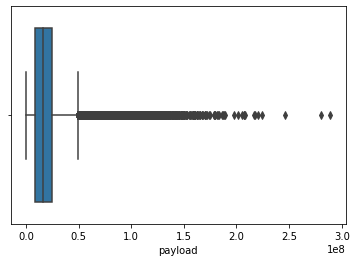

In [44]:
#Checking before-after handling outliers
sns.boxplot(df_ojol['payload'])

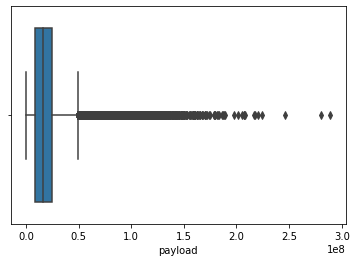

In [45]:
sns.boxplot(df_ojol_2['payload'])

In [46]:
df_ojol_2.describe().T

count     mean      std  min     25%      50%      75%  \
total_revenue         695597   128579   102930    3   75460    99196   160001   
rev_voice             695597     9242    24155    0       0        0     7467   
rev_sms               695597     1051     3918    0       0      165      825   
rev_broadband         695597   108742    79503    0   75000    78801   150000   
rev_voice_pack        695597     3548    15946    0       0        0        0   
rev_sms_pack          695597       28     1274    0       0        0        0   
rev_data_pack         695597   104255    77403    0   75000    75000   150000   
rev_pack_mytsel       695597    12643    58688    0       0        0        0   
trx_voice             695597      107      143    1      19       55      135   
trx_voice_onnet       695597       81      123    0      11       36       99   
trx_voice_offnet      695597       22       35    0       2        9       28   
mou_voice             695597      177      389    0      19       69      191   
mou_voice_onnet       695597      151      381    0       9       43      151   
mou_voice_offnet      695597       20       39    0       1        6       23   
trx_sms               695597       16       94    1       2        5       12   
trx_sms_onnet         695597       13       78    0       1        3        8   
trx_sms_offnet        695597        3       37    0       0        0        2   
payload               695597 18562071 14422573    1 8643818 16331959 24959036   
total_recharge_mytsel 695597      710    27240    0       0        0        0   
los                   695597     1630     1788    1     567     1083     1977   
total_recharge        695597   129171   125605 1000   75000   100000   160000   

                            max  
total_revenue          23756492  
rev_voice               2348500  
rev_sms                  591000  
rev_broadband          13225000  
rev_voice_pack          2348500  
rev_sms_pack             591000  
rev_data_pack          13225000  
rev_pack_mytsel        14265600  
trx_voice                  5606  
trx_voice_onnet            3898  
trx_voice_offnet           1693  
mou_voice                 24798  
mou_voice_onnet           24772  
mou_voice_offnet           2426  
trx_sms                   21210  
trx_sms_onnet             19033  
trx_sms_offnet            20063  
payload               289082688  
total_recharge_mytsel  12750000  
los                        8985  
total_recharge         23756000

### Converting categorical to numerical data

In [47]:
df_ojol_2 = pd.get_dummies(df_ojol_2, drop_first=True)

In [48]:
df_ojol_2.head()

total_revenue  rev_voice  rev_sms  rev_broadband  rev_voice_pack  \
0          10092       8132      800              0               0   
1         133657     131622     1410              0               0   
2          30006      28556     1450              0               0   
3          44503       7133      200              0               0   
4           5073       4473      600              0               0   

   rev_sms_pack  rev_data_pack  rev_pack_mytsel  trx_voice  trx_voice_onnet  \
0             0              0                0         25               12   
1             0              0                0        186              120   
2             0              0                0         36                8   
3             0              0                0         22               15   
4             0              0                0        116              116   

   ...  segment_arpu_Medium (20-50K)  segment_arpu_Top Usage (>250K)  \
0  ...                             0                               0   
1  ...                             0                               0   
2  ...                             1                               0   
3  ...                             1                               0   
4  ...                             0                               0   

   segment_arpu_Very High (120-250K)  segment_arpu_Very Low (<=20K)  \
0                                  0                              1   
1                                  1                              0   
2                                  0                              0   
3                                  0                              0   
4                                  0                              1   

   los_range_1-3mo  los_range_3-6mo  los_range_6-9mo  los_range_9-12mo  \
0                0                0                0                 0   
1                0                0                0                 0   
2                0                0                0                 0   
3                0                0                0                 0   
4                0                0                0                 0   

   los_range_1-3y  los_range_3y+  
0               0              1  
1               0              1  
2               1              0  
3               0              1  
4               0              1  

[5 rows x 58 columns]

### Shifting dependent variable to the end

In [54]:
cols = list(df_ojol_2.columns.values)
cols.pop(cols.index('flag_taker_1'))
df_ojol_2 = df_ojol_2[cols+['flag_taker_1']]
df_ojol_2.head()

total_revenue  rev_voice  rev_sms  rev_broadband  rev_voice_pack  \
0          10092       8132      800              0               0   
1         133657     131622     1410              0               0   
2          30006      28556     1450              0               0   
3          44503       7133      200              0               0   
4           5073       4473      600              0               0   

   rev_sms_pack  rev_data_pack  rev_pack_mytsel  trx_voice  trx_voice_onnet  \
0             0              0                0         25               12   
1             0              0                0        186              120   
2             0              0                0         36                8   
3             0              0                0         22               15   
4             0              0                0        116              116   

   ...  segment_arpu_Top Usage (>250K)  segment_arpu_Very High (120-250K)  \
0  ...                               0                                  0   
1  ...                               0                                  1   
2  ...                               0                                  0   
3  ...                               0                                  0   
4  ...                               0                                  0   

   segment_arpu_Very Low (<=20K)  los_range_1-3mo  los_range_3-6mo  \
0                              1                0                0   
1                              0                0                0   
2                              0                0                0   
3                              0                0                0   
4                              1                0                0   

   los_range_6-9mo  los_range_9-12mo  los_range_1-3y  los_range_3y+  \
0                0                 0               0              1   
1                0                 0               0              1   
2                0                 0               1              0   
3                0                 0               0              1   
4                0                 0               0              1   

   flag_taker_1  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 58 columns]

In [55]:
df_ojol_2.columns

Index(['total_revenue', 'rev_voice', 'rev_sms', 'rev_broadband',
       'rev_voice_pack', 'rev_sms_pack', 'rev_data_pack', 'rev_pack_mytsel',
       'trx_voice', 'trx_voice_onnet', 'trx_voice_offnet', 'mou_voice',
       'mou_voice_onnet', 'mou_voice_offnet', 'trx_sms', 'trx_sms_onnet',
       'trx_sms_offnet', 'payload', 'total_recharge_mytsel', 'los',
       'total_recharge', 'mytsel_app_user_1', 'region_02.Sumbagteng',
       'region_03.Sumbagsel', 'region_04.Western Jabotabek',
       'region_05.Central Jabotabek', 'region_06.Eastern Jabotabek',
       'region_07.Jabar', 'region_08.Jateng', 'region_09.Jatim',
       'region_10.Balinusra', 'region_11.Kalimantan', 'region_12.Sulawesi',
       'region_13.Puma', 'first_rank_category_Communications',
       'first_rank_category_Education', 'first_rank_category_FoodDrinks',
       'first_rank_category_Games', 'first_rank_category_Music',
       'first_rank_category_News_Lifestyle', 'first_rank_category_Others',
       'first_rank_categor

### EDA Part 2

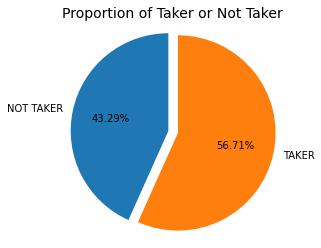

In [56]:
labels = 'NOT TAKER', 'TAKER'
sizes = [df_ojol_2.flag_taker_1[df_ojol_2['flag_taker_1']==0].count(), df_ojol_2.flag_taker_1[df_ojol_2['flag_taker_1']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(4, 4))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        startangle=90)
ax1.axis('equal')
plt.title("Proportion of Taker or Not Taker", size=14)
plt.show()

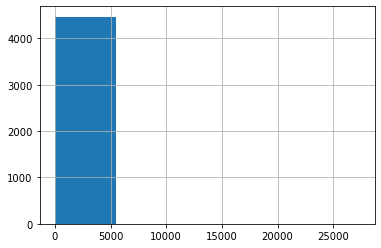

In [57]:
#ojol_clean['los'].value_counts().hist(bins=3);
df_ojol_2['los'].value_counts().hist(bins=5)

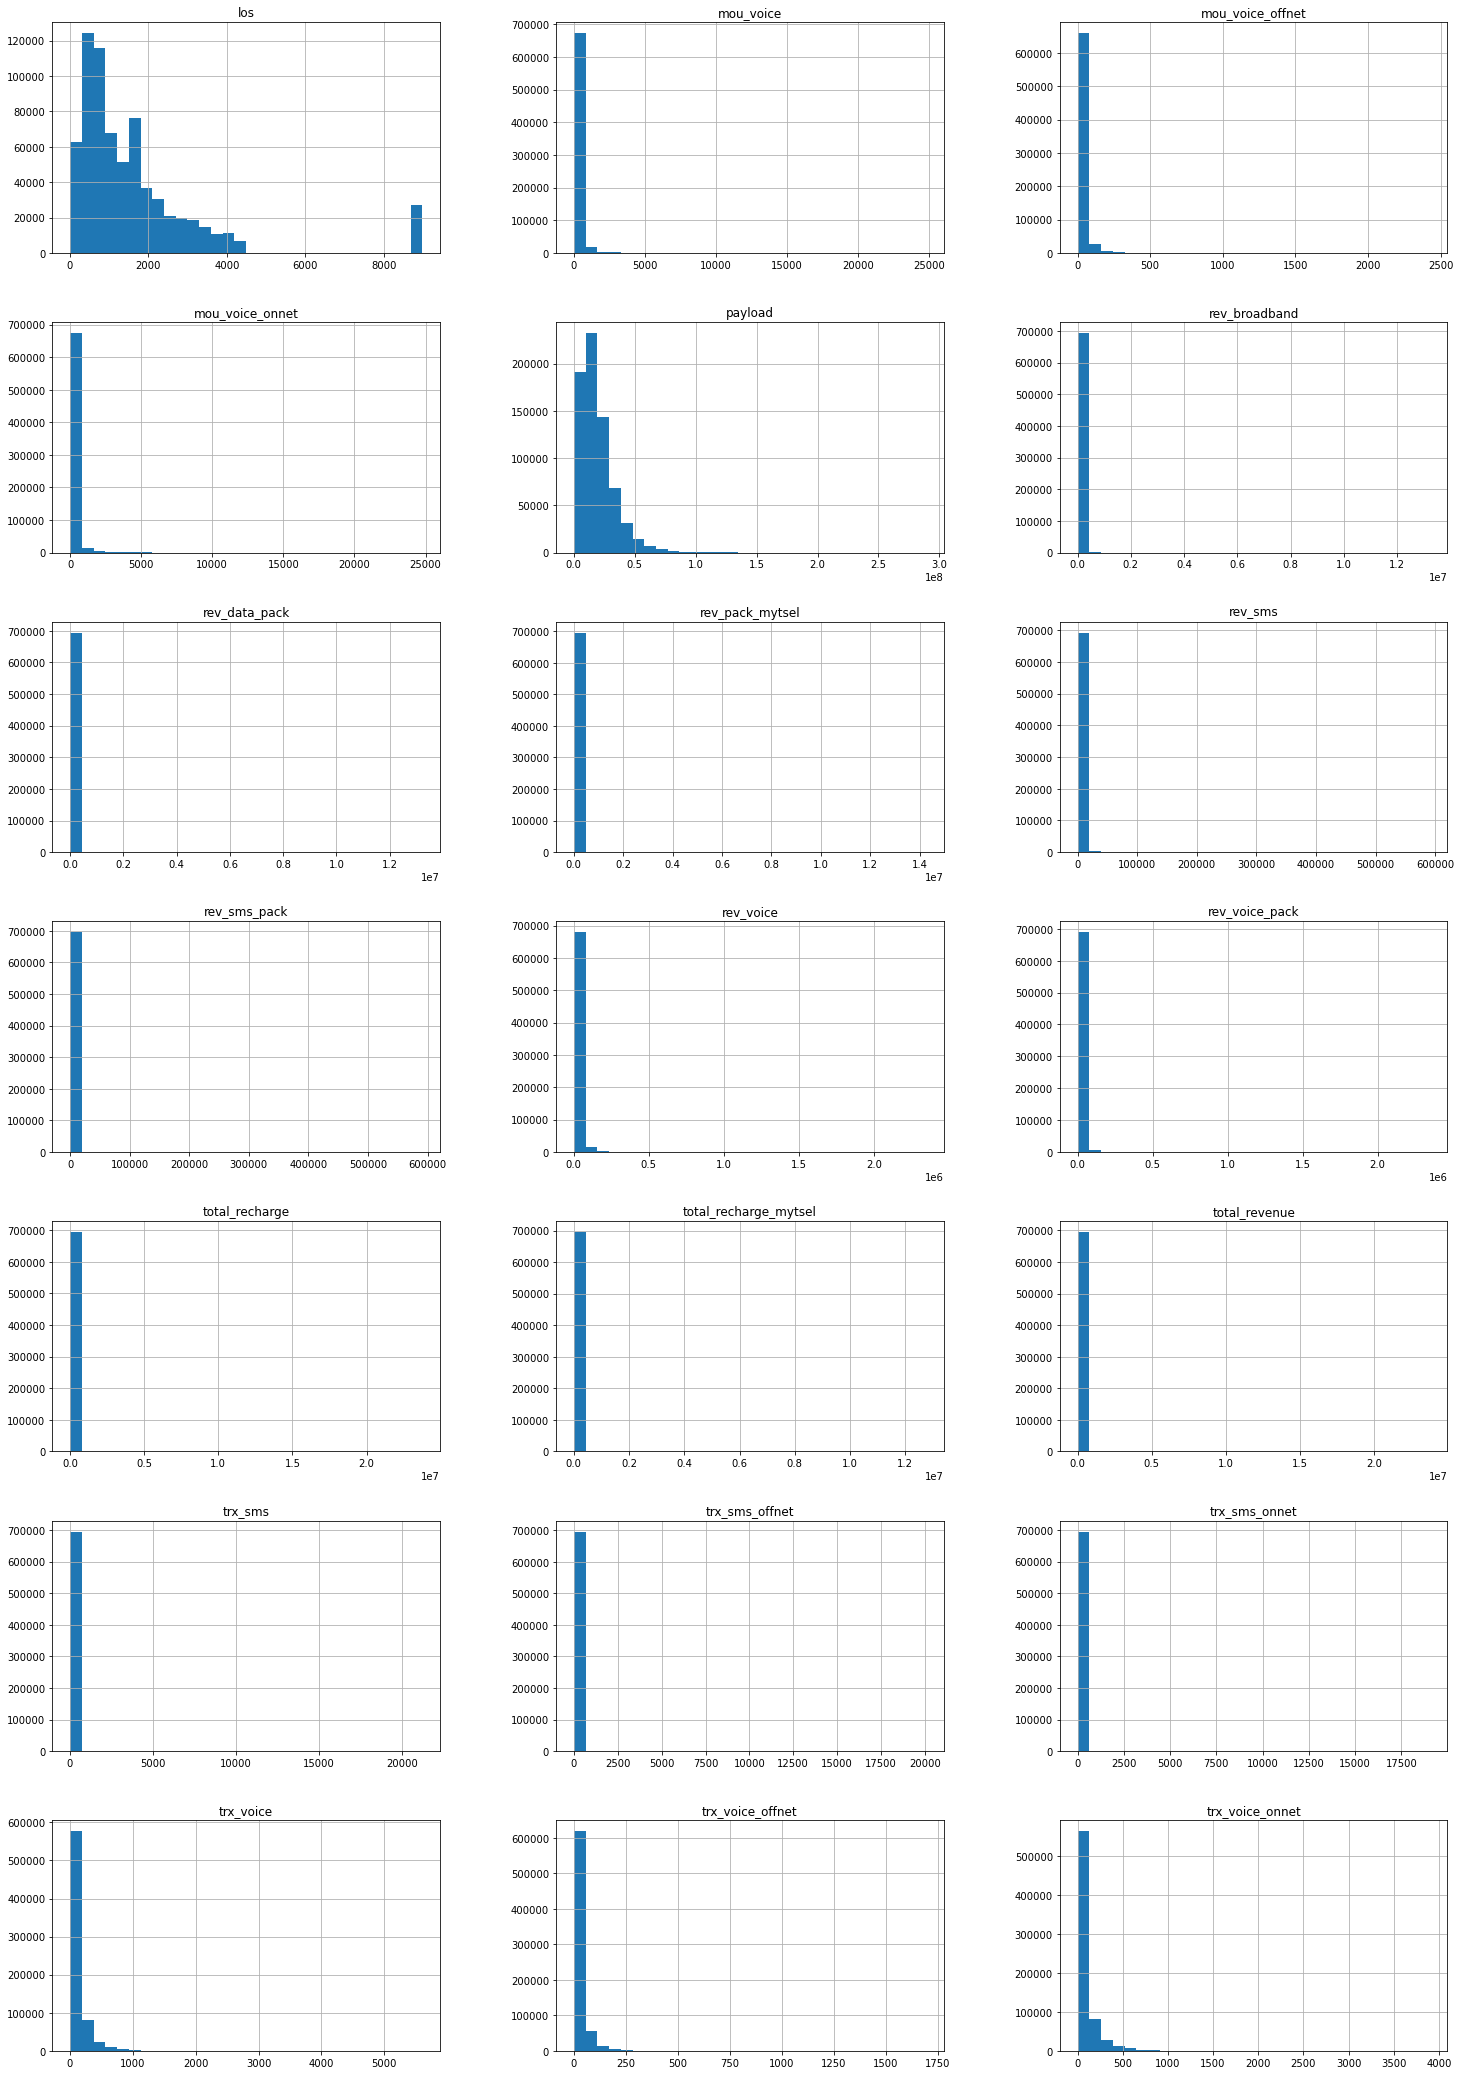

In [58]:
df_ojol_2.hist(column=['total_revenue','rev_voice','rev_sms','rev_broadband','rev_voice_pack','rev_sms_pack','rev_data_pack','rev_pack_mytsel','trx_voice', 'trx_voice_onnet','trx_voice_offnet','mou_voice','mou_voice_offnet','mou_voice_onnet','trx_sms','trx_sms_onnet','trx_sms_offnet','payload','total_recharge_mytsel','los','total_recharge'], bins=30, figsize=(25, 120), layout=(22, 3));


## Feature Engineering

In [59]:
#Ratio revenue per service (voice/sms/broadband) terhadap total revenue
df_ojol_2['rev_voice_ratio']=df_ojol_2['rev_voice']/df_ojol_2['total_revenue']
df_ojol_2['rev_voice_ratio']=df_ojol_2['rev_voice_ratio'].fillna(value=0)

df_ojol_2['rev_sms_ratio']=df_ojol_2['rev_sms']/df_ojol_2['total_revenue']
df_ojol_2['rev_sms_ratio']=df_ojol_2['rev_sms_ratio'].fillna(value=0)

df_ojol_2['rev_broadband_ratio']=df_ojol_2['rev_broadband']/df_ojol_2['total_revenue']
df_ojol_2['rev_broadband_ratio']=df_ojol_2['rev_broadband_ratio'].fillna(value=0)

In [60]:
#Ratio trx voice onnet atau offnet terhadap total trx voice secara menyeluruh
df_ojol_2['trx_voice_onnet_ratio']=df_ojol_2['trx_voice_onnet']/df_ojol_2['trx_voice']
df_ojol_2['trx_voice_onnet_ratio']=df_ojol_2['trx_voice_onnet_ratio'].fillna(value=0)

df_ojol_2['trx_voice_offnet_ratio']=df_ojol_2['trx_voice_offnet']/df_ojol_2['trx_voice']
df_ojol_2['trx_voice_offnet_ratio']=df_ojol_2['trx_voice_offnet_ratio'].fillna(value=0)

In [61]:
#Ratio trx sms onnet atau offnet terhadap total trx sms secara menyeluruh
df_ojol_2['trx_sms_onnet_ratio']=df_ojol_2['trx_sms_onnet']/df_ojol_2['trx_sms']
df_ojol_2['trx_sms_onnet_ratio']=df_ojol_2['trx_sms_onnet_ratio'].fillna(value=0)

df_ojol_2['trx_sms_offnet_ratio']=df_ojol_2['trx_sms_offnet']/df_ojol_2['trx_sms']
df_ojol_2['trx_sms_offnet_ratio']=df_ojol_2['trx_sms_offnet_ratio'].fillna(value=0)

In [62]:
df_ojol_2['mou_voice_onnet_ratio']=df_ojol_2['mou_voice_onnet']/df_ojol_2['mou_voice']
df_ojol_2['mou_voice_onnet_ratio']=df_ojol_2['mou_voice_onnet_ratio'].fillna(value=0)

df_ojol_2['mou_voice_offnet_ratio']=df_ojol_2['mou_voice_offnet']/df_ojol_2['mou_voice']
df_ojol_2['mou_voice_offnet_ratio']=df_ojol_2['mou_voice_offnet_ratio'].fillna(value=0)

In [63]:
df_ojol_2['recharge_revenue_ratio']=df_ojol_2['total_recharge']/df_ojol_2['total_revenue']
df_ojol_2['recharge_revenue_ratio']=df_ojol_2['recharge_revenue_ratio'].fillna(value=0)

In [64]:
df_ojol_2['average_rev_voice_per_trx']=(df_ojol_2['rev_voice'])/df_ojol_2['trx_voice']
df_ojol_2['average_rev_voice_per_trx']=df_ojol_2['average_rev_voice_per_trx'].fillna(value=0)

In [65]:
df_ojol_2['average_rev_sms_per_trx']=(df_ojol_2['rev_sms'])/df_ojol_2['trx_sms']
df_ojol_2['average_rev_sms_per_trx']=df_ojol_2['average_rev_sms_per_trx'].fillna(value=0)

In [66]:
df_ojol_2['average_rev_data_per_trx']=(df_ojol_2['rev_broadband'])/df_ojol_2['payload']
df_ojol_2['average_rev_data_per_trx']=df_ojol_2['average_rev_data_per_trx'].fillna(value=0)

In [67]:
df_ojol_2['average_mou_voice_per_trx']=(df_ojol_2['mou_voice'])/df_ojol_2['trx_voice']
df_ojol_2['average_mou_voice_per_trx']=df_ojol_2['average_mou_voice_per_trx'].fillna(value=0)

In [68]:
df_ojol_2.columns

Index(['total_revenue', 'rev_voice', 'rev_sms', 'rev_broadband',
       'rev_voice_pack', 'rev_sms_pack', 'rev_data_pack', 'rev_pack_mytsel',
       'trx_voice', 'trx_voice_onnet', 'trx_voice_offnet', 'mou_voice',
       'mou_voice_onnet', 'mou_voice_offnet', 'trx_sms', 'trx_sms_onnet',
       'trx_sms_offnet', 'payload', 'total_recharge_mytsel', 'los',
       'total_recharge', 'mytsel_app_user_1', 'region_02.Sumbagteng',
       'region_03.Sumbagsel', 'region_04.Western Jabotabek',
       'region_05.Central Jabotabek', 'region_06.Eastern Jabotabek',
       'region_07.Jabar', 'region_08.Jateng', 'region_09.Jatim',
       'region_10.Balinusra', 'region_11.Kalimantan', 'region_12.Sulawesi',
       'region_13.Puma', 'first_rank_category_Communications',
       'first_rank_category_Education', 'first_rank_category_FoodDrinks',
       'first_rank_category_Games', 'first_rank_category_Music',
       'first_rank_category_News_Lifestyle', 'first_rank_category_Others',
       'first_rank_categor

In [69]:
df_ojol_2.head(5)

total_revenue  rev_voice  rev_sms  rev_broadband  rev_voice_pack  \
0          10092       8132      800              0               0   
1         133657     131622     1410              0               0   
2          30006      28556     1450              0               0   
3          44503       7133      200              0               0   
4           5073       4473      600              0               0   

   rev_sms_pack  rev_data_pack  rev_pack_mytsel  trx_voice  trx_voice_onnet  \
0             0              0                0         25               12   
1             0              0                0        186              120   
2             0              0                0         36                8   
3             0              0                0         22               15   
4             0              0                0        116              116   

   ...  trx_voice_offnet_ratio  trx_sms_onnet_ratio  trx_sms_offnet_ratio  \
0  ...                       0                    1                     0   
1  ...                       0                    1                     0   
2  ...                       1                    0                     1   
3  ...                       0                    1                     0   
4  ...                       0                    1                     0   

   mou_voice_onnet_ratio  mou_voice_offnet_ratio  recharge_revenue_ratio  \
0                      0                       0                       1   
1                      1                       0                       1   
2                      0                       1                       1   
3                      1                       0                       0   
4                      1                       0                       3   

   average_rev_voice_per_trx  average_rev_sms_per_trx  \
0                        325                      200   
1                        708                      201   
2                        793                      207   
3                        324                      200   
4                         39                      100   

   average_rev_data_per_trx  average_mou_voice_per_trx  
0                         0                          0  
1                         0                          1  
2                         0                          1  
3                         0                          1  
4                         0                          1  

[5 rows x 72 columns]

## Feature Selection

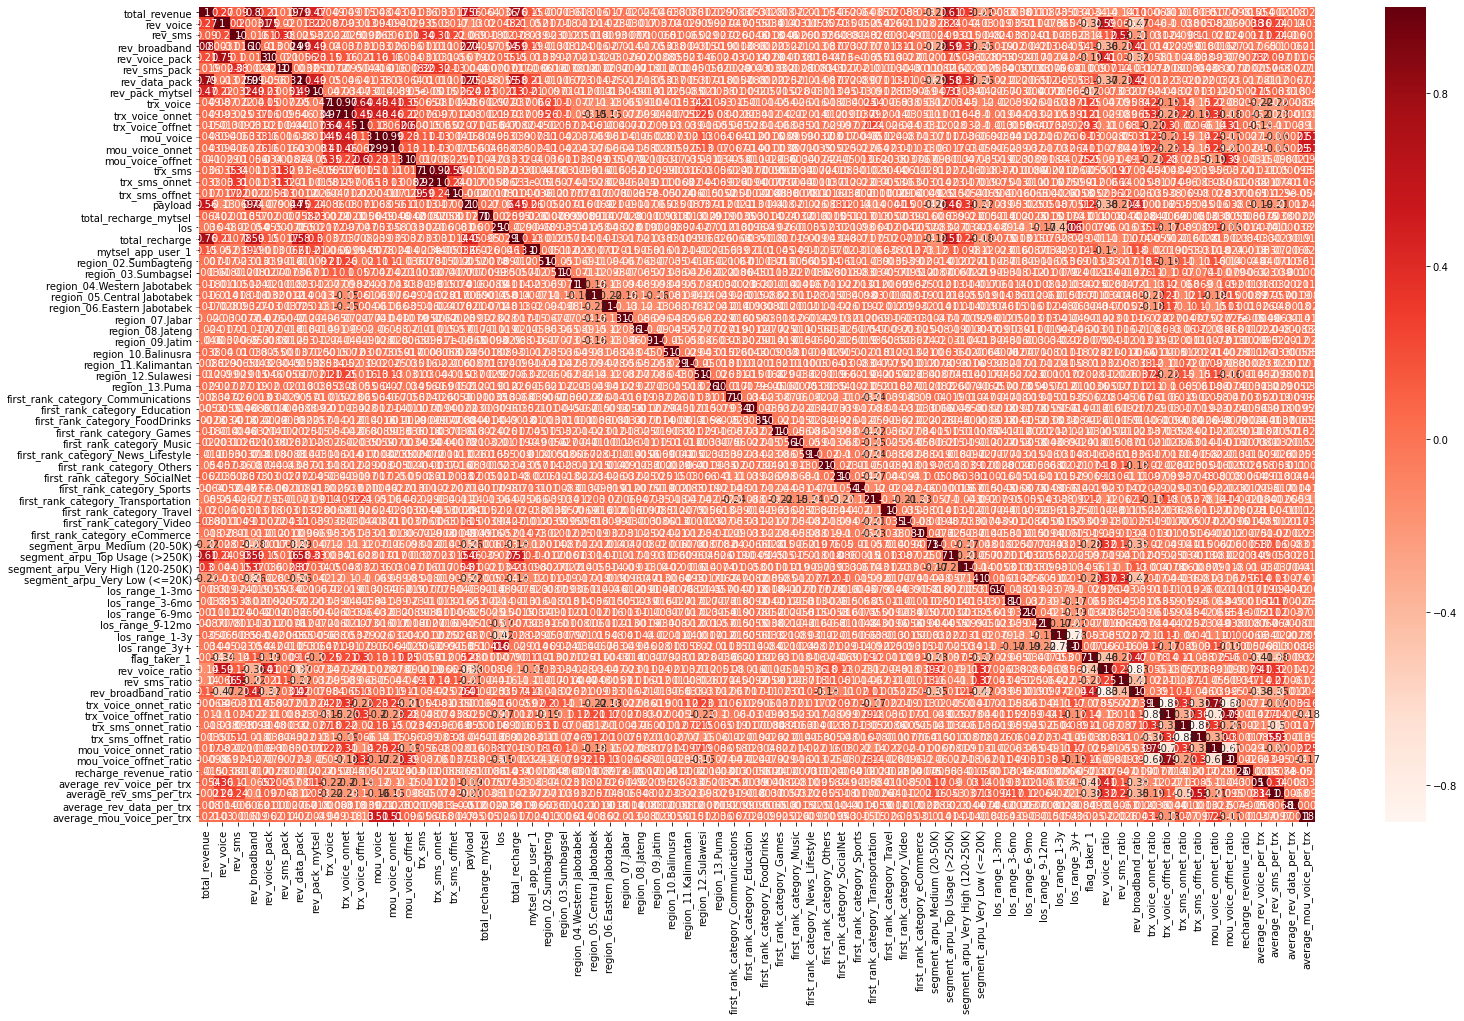

In [70]:
#FILTER METHOD
#Using Pearson Correlation
plt.figure(figsize=(25,15))
cor = df_ojol_2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [71]:
#Correlation with output variable
cor_target = abs(cor["flag_taker_1"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

rev_voice                            0
rev_sms                              0
rev_broadband                        0
rev_voice_pack                       0
rev_data_pack                        0
rev_pack_mytsel                      0
trx_voice                            0
trx_voice_onnet                      0
trx_voice_offnet                     0
mou_voice                            0
mou_voice_onnet                      0
mou_voice_offnet                     0
payload                              0
mytsel_app_user_1                    0
first_rank_category_Transportation   0
segment_arpu_Medium (20-50K)         0
segment_arpu_Very Low (<=20K)        0
flag_taker_1                         1
rev_voice_ratio                      0
rev_sms_ratio                        0
rev_broadband_ratio                  0
trx_voice_offnet_ratio               0
trx_sms_onnet_ratio                  0
mou_voice_offnet_ratio               0
average_rev_voice_per_trx            0
average_rev_sms_per_trx  

In [72]:
columns=relevant_features.index 
columns.to_frame(index=False)

0
0                            rev_voice
1                              rev_sms
2                        rev_broadband
3                       rev_voice_pack
4                        rev_data_pack
5                      rev_pack_mytsel
6                            trx_voice
7                      trx_voice_onnet
8                     trx_voice_offnet
9                            mou_voice
10                     mou_voice_onnet
11                    mou_voice_offnet
12                             payload
13                   mytsel_app_user_1
14  first_rank_category_Transportation
15        segment_arpu_Medium (20-50K)
16       segment_arpu_Very Low (<=20K)
17                        flag_taker_1
18                     rev_voice_ratio
19                       rev_sms_ratio
20                 rev_broadband_ratio
21              trx_voice_offnet_ratio
22                 trx_sms_onnet_ratio
23              mou_voice_offnet_ratio
24           average_rev_voice_per_trx
25             average_rev_sms_per_trx

In [73]:
df_ojol_3 = df_ojol_2[columns]

print("{} rows x {} columns".format(df_ojol_3.shape[0], df_ojol_3.shape[1])) 

695597 rows x 26 columns


In [74]:
df_ojol_3.head()

rev_voice  rev_sms  rev_broadband  rev_voice_pack  rev_data_pack  \
0       8132      800              0               0              0   
1     131622     1410              0               0              0   
2      28556     1450              0               0              0   
3       7133      200              0               0              0   
4       4473      600              0               0              0   

   rev_pack_mytsel  trx_voice  trx_voice_onnet  trx_voice_offnet  mou_voice  \
0                0         25               12                12          6   
1                0        186              120                66        102   
2                0         36                8                28         21   
3                0         22               15                 7         21   
4                0        116              116                 0        147   

   ...  segment_arpu_Very Low (<=20K)  flag_taker_1  rev_voice_ratio  \
0  ...                              1             0                1   
1  ...                              0             0                1   
2  ...                              0             0                1   
3  ...                              0             0                0   
4  ...                              1             0                1   

   rev_sms_ratio  rev_broadband_ratio  trx_voice_offnet_ratio  \
0              0                    0                       0   
1              0                    0                       0   
2              0                    0                       1   
3              0                    0                       0   
4              0                    0                       0   

   trx_sms_onnet_ratio  mou_voice_offnet_ratio  average_rev_voice_per_trx  \
0                    1                       0                        325   
1                    1                       0                        708   
2                    0                       1                        793   
3                    1                       0                        324   
4                    1                       0                         39   

   average_rev_sms_per_trx  
0                      200  
1                      201  
2                      207  
3                      200  
4                      100  

[5 rows x 26 columns]

## merging flag_taker_1 with df_ojol_3

In [76]:
df_ojol_2_ft = df_ojol_2['flag_taker_1']

In [77]:
df_ojol_x = df_ojol_3.merge(df_ojol_2_ft, left_index=True, right_index=True)

In [78]:
df_ojol_x

rev_voice  rev_sms  rev_broadband  rev_voice_pack  rev_data_pack  \
0            8132      800              0               0              0   
1          131622     1410              0               0              0   
2           28556     1450              0               0              0   
3            7133      200              0               0              0   
4            4473      600              0               0              0   
...           ...      ...            ...             ...            ...   
695592        281      350          96879               0          75000   
695593      51450      495          33084               0          33003   
695594          0      495          99996               0          75000   
695595          0      165          75000               0          75000   
695596       2046        0         225004               0         225000   

        rev_pack_mytsel  trx_voice  trx_voice_onnet  trx_voice_offnet  \
0                     0         25               12                12   
1                     0        186              120                66   
2                     0         36                8                28   
3                     0         22               15                 7   
4                     0        116              116                 0   
...                 ...        ...              ...               ...   
695592                0        378              354                23   
695593                0        227              198                28   
695594                0        168              125                38   
695595                0        296              255                36   
695596                0        284              251                32   

        mou_voice  ...  flag_taker_1_x  rev_voice_ratio  rev_sms_ratio  \
0               6  ...               0                1              0   
1             102  ...               0                1              0   
2              21  ...               0                1              0   
3              21  ...               0                0              0   
4             147  ...               0                1              0   
...           ...  ...             ...              ...            ...   
695592        643  ...               1                0              0   
695593         79  ...               0                1              0   
695594        488  ...               1                0              0   
695595        687  ...               1                0              0   
695596        777  ...               1                0              0   

        rev_broadband_ratio  trx_voice_offnet_ratio  trx_sms_onnet_ratio  \
0                         0                       0                    1   
1                         0                       0                    1   
2                         0                       1                    0   
3                         0                       0                    1   
4                         0                       0                    1   
...                     ...                     ...                  ...   
695592                    1                       0                    1   
695593                    0                       0                    1   
695594                    1                       0                    0   
695595                    1                       0                    0   
695596                    1                       0                    1   

        mou_voice_offnet_ratio  average_rev_voice_per_trx  \
0                            0                        325   
1                            0                        708   
2                            1                        793   
3                            0                        324   
4                            0                         39   
...                        ...                    

# MODELING

## Split Data

In [91]:
pd.set_option('display.max_columns', 50)

In [96]:
df_ojol_x = df_ojol_x.drop(['flag_taker_1_x'], axis = 1) # ini ada flag_taker_1_x sama flag_taker_1_y apa ya?

In [98]:
from sklearn.model_selection import train_test_split
X = df_ojol_x.iloc[:, :25]
Y = df_ojol_x.iloc[:, 25:]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 10)

## Feature Scaling

In [100]:
min_test = X_test.min()
range_test = (X_test - min_test).max()
X_test_scaled = (X_test - min_test)/range_test
min_train = X_train.min()
range_train = (X_train - min_train).max()
X_train_scaled = (X_train - min_train)/range_train

In [101]:
min_test_2 = X.min()
range_test_2 = (X - min_test_2).max()
X_scaled = (X - min_test_2)/range_test_2

In [102]:
X_train_scaled = X_train_scaled.reset_index(drop=True)
X_test_scaled = X_test_scaled.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

## Cross Validation Multi Model

In [103]:
X_train_scaled_2 = X_train_scaled.iloc[:1001, :]
Y_train_2 = Y_train.iloc[:1001, :]
X_test_scaled_2 = X_test_scaled.iloc[:1001, :]
Y_test_2 = Y_test.iloc[:1001, :]
X_scaled_2 = X_scaled.iloc[:10001, :]
Y_2 = Y.iloc[:10001, :]
X_2 = X.iloc[:10001, :]

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [105]:
logr = LogisticRegression()
svc = SVC()
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=10)
dc_reg = DecisionTreeRegressor()
dc_clas = DecisionTreeClassifier()
random_fc = RandomForestClassifier(n_estimators = 10)
km = KMeans()
print(cross_val_score(logr, X_2, Y_2, cv=5, scoring='accuracy').mean())
print(cross_val_score(svc, X_2, Y_2, cv=5, scoring='accuracy').mean())
print(cross_val_score(gnb, X_2, Y_2, cv=5, scoring='accuracy').mean()) 
print(cross_val_score(knn, X_2, Y_2, cv=5, scoring='accuracy').mean()) 
print(cross_val_score(dc_reg, X_2, Y_2, cv=5, scoring='accuracy').mean())
print(cross_val_score(dc_clas, X_2, Y_2, cv=5, scoring='accuracy').mean()) 
print(cross_val_score(random_fc, X_2, Y_2, cv=5, scoring='accuracy').mean())  
print(cross_val_score(km, X_2, Y_2, cv=5, scoring='accuracy').mean())  

0.8089174412793604
0.6978297351324338
0.719827036481759
0.7341258870564717
0.8185170414792603
0.8192166416791604
0.8698116441779111
0.17677621189405296


## Modeling

In [106]:
from sklearn.ensemble import RandomForestClassifier
modelC = RandomForestClassifier(random_state=0, n_estimators=500, max_depth=1)
modelC.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

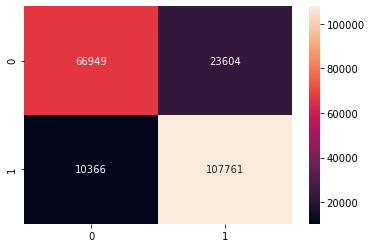

In [107]:
from sklearn.metrics import confusion_matrix
Y_predict = modelC.predict(X_test)
cm = confusion_matrix(Y_test, Y_predict)
sns.heatmap(cm, annot=True, fmt="d")

In [108]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80     90553
           1       0.82      0.91      0.86    118127

    accuracy                           0.84    208680
   macro avg       0.84      0.83      0.83    208680
weighted avg       0.84      0.84      0.84    208680



## Model Interpretability

### SHAP Values

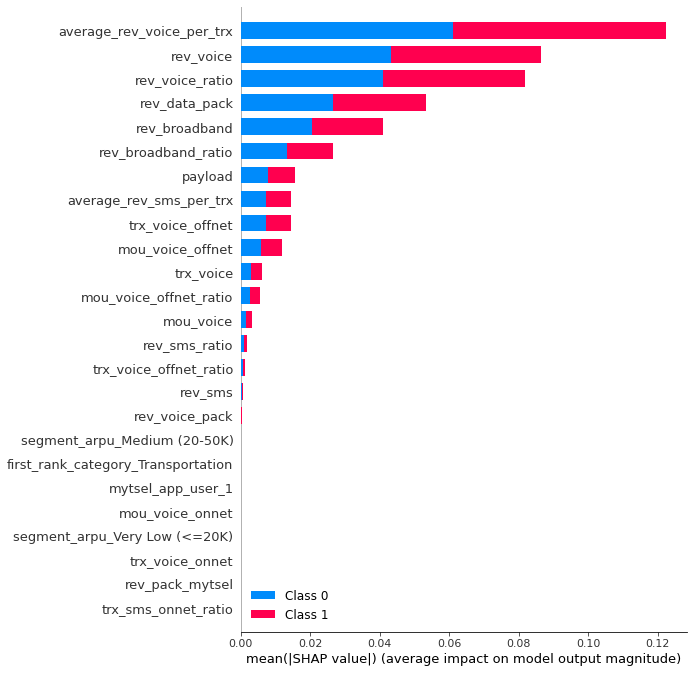

In [109]:
shap_values = shap.TreeExplainer(modelC).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display = 28)

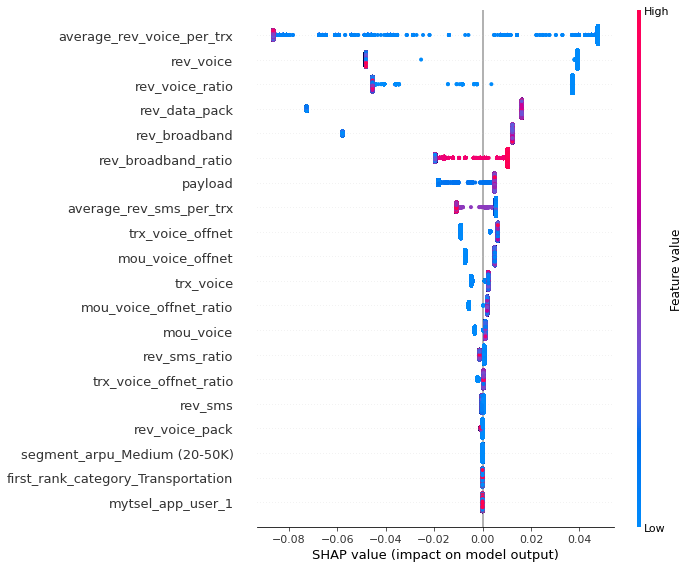

In [110]:
explainer = shap.TreeExplainer(modelC)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

In [111]:
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [112]:
row_to_show = 50
data_for_prediction = X_test.iloc[row_to_show]
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

### Lime

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_lbenc.values,  # Label Encoded Numpy Format
                                                   feature_names = X_train_lbenc.columns,
                                                   class_names = [
                                                       'dead', 'survive' ], # 0,1,...
                                                   categorical_features = cat_list,
                                                   categorical_names = cat_dic,
                                                   mode = 'classification'
                                                   )

In [113]:
import lime
import lime.lime_tabular

In [114]:
X.columns

Index(['rev_voice', 'rev_sms', 'rev_broadband', 'rev_voice_pack',
       'rev_data_pack', 'rev_pack_mytsel', 'trx_voice', 'trx_voice_onnet',
       'trx_voice_offnet', 'mou_voice', 'mou_voice_onnet', 'mou_voice_offnet',
       'payload', 'mytsel_app_user_1', 'first_rank_category_Transportation',
       'segment_arpu_Medium (20-50K)', 'segment_arpu_Very Low (<=20K)',
       'rev_voice_ratio', 'rev_sms_ratio', 'rev_broadband_ratio',
       'trx_voice_offnet_ratio', 'trx_sms_onnet_ratio',
       'mou_voice_offnet_ratio', 'average_rev_voice_per_trx',
       'average_rev_sms_per_trx'],
      dtype='object')

In [115]:
feature_names = ['rev_voice', 'rev_sms', 'rev_broadband', 'rev_voice_pack',
       'rev_data_pack', 'rev_pack_mytsel', 'trx_voice', 'trx_voice_onnet',
       'trx_voice_offnet', 'mou_voice', 'mou_voice_onnet', 'mou_voice_offnet',
       'payload', 'mytsel_app_user_1', 'first_rank_category_Transportation',
       'segment_arpu_Medium (20-50K)', 'segment_arpu_Very Low (<=20K)',
       'rev_voice_ratio', 'rev_sms_ratio', 'rev_broadband_ratio',
       'trx_voice_offnet_ratio', 'trx_sms_onnet_ratio',
       'mou_voice_offnet_ratio', 'average_rev_voice_per_trx',
       'average_rev_sms_per_trx']

In [122]:
class_names = ['Non Buyer','Buyer']
explainerL = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
feature_names=feature_names, class_names=class_names, discretize_continuous=True)

expL = explainerL.explain_instance(X_test.iloc[50],modelC.predict_proba,num_features=25,top_labels=1)

expL.show_in_notebook(show_table=True, show_all=False)

## ELI5

In [120]:
import eli5

Using TensorFlow backend.


In [121]:
eli5.show_weights(modelC,feature_names=feature_names,target_names=class_names)
eli5.show_prediction(modelC, X_test.iloc[50],feature_names=feature_names,target_names=class_names)

# Modelling application

In [125]:
df_ojol_x_0 = df_ojol_x[df_ojol_x['flag_taker_1_y']==0]
df_ojol_x_0

rev_voice  rev_sms  rev_broadband  rev_voice_pack  rev_data_pack  \
0            8132      800              0               0              0   
1          131622     1410              0               0              0   
2           28556     1450              0               0              0   
3            7133      200              0               0              0   
4            4473      600              0               0              0   
...           ...      ...            ...             ...            ...   
695583      10085      660            595            1250              0   
695584          0        0          75000               0          75000   
695588          0        0          90000               0          90000   
695590          0        0         152162               0         150000   
695593      51450      495          33084               0          33003   

        rev_pack_mytsel  trx_voice  trx_voice_onnet  trx_voice_offnet  \
0                     0         25               12                12   
1                     0        186              120                66   
2                     0         36                8                28   
3                     0         22               15                 7   
4                     0        116              116                 0   
...                 ...        ...              ...               ...   
695583                0          9                8                 0   
695584                0        131              109                19   
695588                0         65               65                 0   
695590                0         43               43                 0   
695593                0        227              198                28   

        mou_voice  mou_voice_onnet  mou_voice_offnet   payload  \
0               6                2                 3   9229653   
1             102               63                38   3668863   
2              21                4                16   2097283   
3              21               17                 3   1974025   
4             147              147                 0  10023262   
...           ...              ...               ...       ...   
695583         11               11                 0      3780   
695584         92               69                10   6738164   
695588         74               74                 0  13928657   
695590       2898             2898                 0  24119752   
695593         79               68                 9   5589650   

        mytsel_app_user_1  first_rank_category_Transportation  \
0                       1                                   1   
1                       0                                   1   
2                       0                                   1   
3                       1                                   0   
4                       1                                   1   
...                   ...                                 ...   
695583                  0                                   0   
695584                  1                                   1   
695588                  0                                   0   
695590                  1                                   0   
695593                  0                                   1   

        segment_arpu_Medium (20-50K)  segment_arpu_Very Low (<=20K)  \
0                                  0                              1   
1                                  0                              0   
2                                  1                              0   
3                                  1                              0   
4                                  0                              1   
...                              ...                            ...   
695583                             0                              1   
695584                             0                              0   
69558

In [126]:
df_ojol_x_0 = df_ojol_x_0.drop(['flag_taker_1_y'], axis = 1)
df_ojol_x_0

rev_voice  rev_sms  rev_broadband  rev_voice_pack  rev_data_pack  \
0            8132      800              0               0              0   
1          131622     1410              0               0              0   
2           28556     1450              0               0              0   
3            7133      200              0               0              0   
4            4473      600              0               0              0   
...           ...      ...            ...             ...            ...   
695583      10085      660            595            1250              0   
695584          0        0          75000               0          75000   
695588          0        0          90000               0          90000   
695590          0        0         152162               0         150000   
695593      51450      495          33084               0          33003   

        rev_pack_mytsel  trx_voice  trx_voice_onnet  trx_voice_offnet  \
0                     0         25               12                12   
1                     0        186              120                66   
2                     0         36                8                28   
3                     0         22               15                 7   
4                     0        116              116                 0   
...                 ...        ...              ...               ...   
695583                0          9                8                 0   
695584                0        131              109                19   
695588                0         65               65                 0   
695590                0         43               43                 0   
695593                0        227              198                28   

        mou_voice  mou_voice_onnet  mou_voice_offnet   payload  \
0               6                2                 3   9229653   
1             102               63                38   3668863   
2              21                4                16   2097283   
3              21               17                 3   1974025   
4             147              147                 0  10023262   
...           ...              ...               ...       ...   
695583         11               11                 0      3780   
695584         92               69                10   6738164   
695588         74               74                 0  13928657   
695590       2898             2898                 0  24119752   
695593         79               68                 9   5589650   

        mytsel_app_user_1  first_rank_category_Transportation  \
0                       1                                   1   
1                       0                                   1   
2                       0                                   1   
3                       1                                   0   
4                       1                                   1   
...                   ...                                 ...   
695583                  0                                   0   
695584                  1                                   1   
695588                  0                                   0   
695590                  1                                   0   
695593                  0                                   1   

        segment_arpu_Medium (20-50K)  segment_arpu_Very Low (<=20K)  \
0                                  0                              1   
1                                  0                              0   
2                                  1                              0   
3                                  1                              0   
4                                  0                              1   
...                              ...                            ...   
695583                             0                              1   
695584                             0                              0   
69558

In [127]:
y_nontaker_predict_taker = modelC.predict(df_ojol_x_0)
print(y_nontaker_predict_taker)

[0 0 0 ... 1 1 0]


In [128]:
y_nontaker_predict_taker = pd.DataFrame(y_nontaker_predict_taker)
y_nontaker_predict_taker.columns =['flag_taker_predicted']
y_nontaker_predict_taker

flag_taker_predicted
0                          0
1                          0
2                          0
3                          0
4                          0
...                      ...
301151                     0
301152                     1
301153                     1
301154                     1
301155                     0

[301156 rows x 1 columns]

## Resetting INDEX

In [129]:
y_nontaker_predict_taker.reset_index(drop=True, inplace=True)
df_ojol_x_0.reset_index(drop=True, inplace=True)

In [130]:
df_final = df_ojol_x_0.join(y_nontaker_predict_taker)
df_final

rev_voice  rev_sms  rev_broadband  rev_voice_pack  rev_data_pack  \
0            8132      800              0               0              0   
1          131622     1410              0               0              0   
2           28556     1450              0               0              0   
3            7133      200              0               0              0   
4            4473      600              0               0              0   
...           ...      ...            ...             ...            ...   
301151      10085      660            595            1250              0   
301152          0        0          75000               0          75000   
301153          0        0          90000               0          90000   
301154          0        0         152162               0         150000   
301155      51450      495          33084               0          33003   

        rev_pack_mytsel  trx_voice  trx_voice_onnet  trx_voice_offnet  \
0                     0         25               12                12   
1                     0        186              120                66   
2                     0         36                8                28   
3                     0         22               15                 7   
4                     0        116              116                 0   
...                 ...        ...              ...               ...   
301151                0          9                8                 0   
301152                0        131              109                19   
301153                0         65               65                 0   
301154                0         43               43                 0   
301155                0        227              198                28   

        mou_voice  mou_voice_onnet  mou_voice_offnet   payload  \
0               6                2                 3   9229653   
1             102               63                38   3668863   
2              21                4                16   2097283   
3              21               17                 3   1974025   
4             147              147                 0  10023262   
...           ...              ...               ...       ...   
301151         11               11                 0      3780   
301152         92               69                10   6738164   
301153         74               74                 0  13928657   
301154       2898             2898                 0  24119752   
301155         79               68                 9   5589650   

        mytsel_app_user_1  first_rank_category_Transportation  \
0                       1                                   1   
1                       0                                   1   
2                       0                                   1   
3                       1                                   0   
4                       1                                   1   
...                   ...                                 ...   
301151                  0                                   0   
301152                  1                                   1   
301153                  0                                   0   
301154                  1                                   0   
301155                  0                                   1   

        segment_arpu_Medium (20-50K)  segment_arpu_Very Low (<=20K)  \
0                                  0                              1   
1                                  0                              0   
2                                  1                              0   
3                                  1                              0   
4                                  0                              1   
...                              ...                            ...   
301151                             0                              1   
301152                             0                              0   
30115

In [131]:
df_final['flag_taker_predicted'].value_counts()

0    222194
1     78962
Name: flag_taker_predicted, dtype: int64

In [132]:
df_final_1 = df_final[df_final['flag_taker_predicted']==1]
df_final_1

rev_voice  rev_sms  rev_broadband  rev_voice_pack  rev_data_pack  \
13           1076        0         190000               0         190000   
14            750      660         245858               0         230000   
16              0     2640          75000               0          75000   
20           4464      325          75000               0          75000   
24              0        0          75000               0          75000   
...           ...      ...            ...             ...            ...   
301149          0        0          75000               0          75000   
301150          0      165          87468               0          75000   
301152          0        0          75000               0          75000   
301153          0        0          90000               0          90000   
301154          0        0         152162               0         150000   

        rev_pack_mytsel  trx_voice  trx_voice_onnet  trx_voice_offnet  \
13                    0         41               39                 2   
14               230000         22               21                 1   
16                    0        276              146               121   
20                    0        120              104                14   
24                    0         74               49                25   
...                 ...        ...              ...               ...   
301149                0         26               19                 7   
301150                0        545              384               138   
301152                0        131              109                19   
301153                0         65               65                 0   
301154                0         43               43                 0   

        mou_voice  mou_voice_onnet  mou_voice_offnet   payload  \
13            120              119                 0  36869108   
14             56               56                 0  40238888   
16            386              184               191  17912840   
20            436              400                30  12673050   
24             43               32                10  15791524   
...           ...              ...               ...       ...   
301149         32               21                11   2114973   
301150        252              201                45  24447296   
301152         92               69                10   6738164   
301153         74               74                 0  13928657   
301154       2898             2898                 0  24119752   

        mytsel_app_user_1  first_rank_category_Transportation  \
13                      0                                   0   
14                      1                                   0   
16                      0                                   0   
20                      0                                   1   
24                      0                                   0   
...                   ...                                 ...   
301149                  0                                   0   
301150                  0                                   1   
301152                  1                                   1   
301153                  0                                   0   
301154                  1                                   0   

        segment_arpu_Medium (20-50K)  segment_arpu_Very Low (<=20K)  \
13                                 0                              0   
14                                 0                              0   
16                                 0                              0   
20                                 0                              0   
24                                 0                              0   
...                              ...                            ...   
301149                             0                              0   
301150                             0                              0   
30115

## Clustering using predicted taker (1 only)

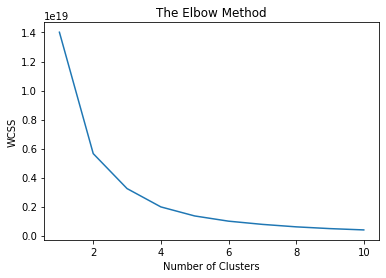

In [133]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 99)
    kmeans.fit(df_final_1)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [134]:
from sklearn.metrics import silhouette_score
for num_clusters in range(2,10):
    clusterer = KMeans(n_clusters=num_clusters, n_jobs=4)
    preds = clusterer.fit_predict(df_final_1)
    # centers = clusterer.cluster_centers_
    score = silhouette_score (df_final_1, preds, metric='euclidean')
    print ("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))

For n_clusters = 2, Kmeans silhouette score is 0.6223928236552998)
For n_clusters = 3, Kmeans silhouette score is 0.5352843473500646)
For n_clusters = 4, Kmeans silhouette score is 0.5493703101999236)
For n_clusters = 5, Kmeans silhouette score is 0.5535046912262914)
For n_clusters = 6, Kmeans silhouette score is 0.5452530519730993)
For n_clusters = 7, Kmeans silhouette score is 0.5337629726107674)
For n_clusters = 8, Kmeans silhouette score is 0.5367757942840374)
For n_clusters = 9, Kmeans silhouette score is 0.5378142192462023)


In [136]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 99)
y_kmeans = kmeans.fit_predict(df_final_1)
y_kmeans_2 = pd.DataFrame(y_kmeans, columns=['cluster'])
y_kmeans_2.reset_index(drop=True, inplace=True)
df_final_1.reset_index(drop=True, inplace=True)
df_final_1_v2 = df_final_1.join(y_kmeans_2)
df_final_1_v2

rev_voice  rev_sms  rev_broadband  rev_voice_pack  rev_data_pack  \
0           1076        0         190000               0         190000   
1            750      660         245858               0         230000   
2              0     2640          75000               0          75000   
3           4464      325          75000               0          75000   
4              0        0          75000               0          75000   
...          ...      ...            ...             ...            ...   
78957          0        0          75000               0          75000   
78958          0      165          87468               0          75000   
78959          0        0          75000               0          75000   
78960          0        0          90000               0          90000   
78961          0        0         152162               0         150000   

       rev_pack_mytsel  trx_voice  trx_voice_onnet  trx_voice_offnet  \
0                    0         41               39                 2   
1               230000         22               21                 1   
2                    0        276              146               121   
3                    0        120              104                14   
4                    0         74               49                25   
...                ...        ...              ...               ...   
78957                0         26               19                 7   
78958                0        545              384               138   
78959                0        131              109                19   
78960                0         65               65                 0   
78961                0         43               43                 0   

       mou_voice  mou_voice_onnet  mou_voice_offnet   payload  \
0            120              119                 0  36869108   
1             56               56                 0  40238888   
2            386              184               191  17912840   
3            436              400                30  12673050   
4             43               32                10  15791524   
...          ...              ...               ...       ...   
78957         32               21                11   2114973   
78958        252              201                45  24447296   
78959         92               69                10   6738164   
78960         74               74                 0  13928657   
78961       2898             2898                 0  24119752   

       mytsel_app_user_1  first_rank_category_Transportation  \
0                      0                                   0   
1                      1                                   0   
2                      0                                   0   
3                      0                                   1   
4                      0                                   0   
...                  ...                                 ...   
78957                  0                                   0   
78958                  0                                   1   
78959                  1                                   1   
78960                  0                                   0   
78961                  1                                   0   

       segment_arpu_Medium (20-50K)  segment_arpu_Very Low (<=20K)  \
0                                 0                              0   
1                                 0                              0   
2                                 0                              0   
3                                 0                              0   
4                                 0                              0   
...                             ...                            ...   
78957                             0                              0   
78958                             0                              0   
78959                             0                          

## export to CSV untuk di profiling clusternya

In [137]:
df_final_1_v2.to_csv(r'D:df_final_1_v2.csv', index = False)